# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "../traffic-signs-data/train.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(train['features'])

# TODO: number of testing examples
n_test = len(test['features'])

# TODO: what's the shape of an image?
sample_image_shape = train['sizes'][0]

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", sample_image_shape)
print("Number of classes =", n_classes)

print("Length features,labels,sizes  =", len(train['features']),"," ,len(train['labels']),",", len(train['sizes']))

#print("1st feature =", train['features'][0])
#print("1st size =", train['sizes'][0])
#print("1st label =", train['labels'][0])
#print("1st coords =", train['coords'][0])


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [29 30]
Number of classes = 43
Length features,labels,sizes  = 39209 , 39209 , 39209


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import scipy as scipy
import math
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [5]:
tf.__version__

'0.11.0'

In [6]:
# Problem 1 - Implement Min-Max scaling for greyscale image data
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [8]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
#enc = preprocessing.OneHotEncoder()
lb.fit(train['labels'])
#print(lb.transform(train['labels']))
train['hot-labels'] = lb.transform(train['labels'])
test['hot-labels'] = lb.transform(test['labels'])

train["input-features"] = []
test["input-features"] = []

image_size_tuple = (30,30,3)
image_size_flat = 30*30*3

for i, option in enumerate(train['features']):
    #print('Size - ', train['sizes'][i])
    #print('Size - ', len(train['features'][i]))
    tempTrainFeature = scipy.misc.imresize(train['features'][i], image_size_tuple , interp='bilinear')
    
    
    trainVertices = np.array([[(train['coords'][i][0],train['coords'][i][1]),
                               (train['coords'][i][0],train['coords'][i][3]), 
                               (train['coords'][i][2],train['coords'][i][3]), 
                               (train['coords'][i][2],train['coords'][i][1])]],
                            dtype=np.int32)
    tempTrainFeature=region_of_interest(tempTrainFeature, trainVertices)
    tempTrainFeature=normalize_greyscale(tempTrainFeature)
    #feature = np.array(tempTrainFeature, dtype=np.float32).flatten()
    tempTrainFeature = tempTrainFeature.reshape(image_size_flat)
    #print(len(feature))
    train["input-features"].append(tempTrainFeature)            
    #print('done - ', i)
for j, option in enumerate(test['features']):
    #print('Size - ', test['sizes'][j])
    tempTestFeature = scipy.misc.imresize(test['features'][j], image_size_tuple, interp='bilinear')
    
    testVertices = np.array([[(test['coords'][j][0],test['coords'][j][1]),
                               (test['coords'][j][0],test['coords'][j][3]), 
                               (test['coords'][j][2],test['coords'][j][3]), 
                               (test['coords'][j][2],test['coords'][j][1])]],
                            dtype=np.int32)
    tempTestFeature=region_of_interest(tempTestFeature, testVertices)
    #testfeature = np.array(tempTestFeature, dtype=np.float32).flatten()
    tempTestFeature=normalize_greyscale(tempTestFeature)
    tempTestFeature = tempTestFeature.reshape(image_size_flat)
    test["input-features"].append(tempTestFeature)
    #print('done - ', j)

print("Train Feature Count = ", len(train["input-features"]))
print("Test Feature Count = ", len(test["input-features"]))
print('Pre processing done.')

Train Feature Count =  39209
Test Feature Count =  12630
Pre processing done.


In [9]:
def plot_images(images, labels, cls_pred=None, rect_coords=None, reshape=True):
    assert len(images) == len(labels) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        #newImgArr = scipy.misc.imresize(images[i], (30,30), interp='bilinear')
        if reshape==False:
            ax.imshow(images[i], cmap='binary') #.reshape(img_shape)
        else:
            ax.imshow(images[i].reshape(image_size_tuple), cmap='binary')
            
        # Create a Rectangle for the co-ordinates
        if rect_coords is not None:
            rect = patches.Rectangle((rect_coords[i][0],rect_coords[i][1]),(rect_coords[i][2]-rect_coords[i][0]),(rect_coords[i][3]-rect_coords[i][1]),linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(labels[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(labels[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

Original Images -
New Reshaped Images -


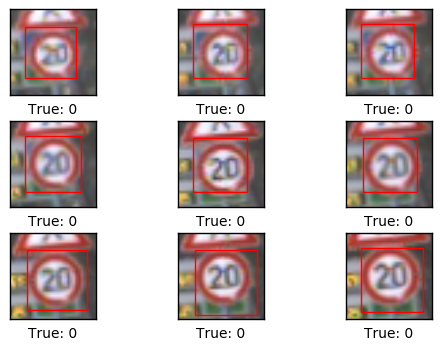

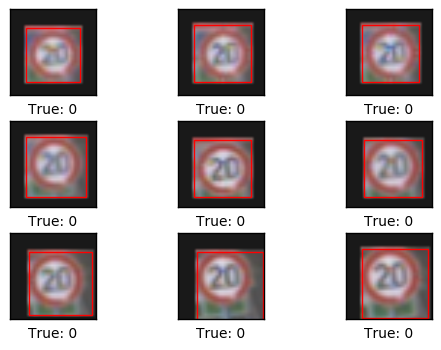

In [10]:
# Get the images from the test-set.
#[38000:38009]
images = train['input-features'][0:9]

# Get the true labels for those images.
labels = train['labels'][0:9]

# Get the sizes for those images.
sizes = train['sizes'][0:9]
coords = train['coords'][0:9]
# Plot the images and labels using our helper-function above.
print("Original Images -")
plot_images(images=train['features'][0:9], labels=labels, cls_pred=None, rect_coords=coords, reshape=False)

print("New Reshaped Images -")
plot_images(images=images, labels=labels, cls_pred=None, rect_coords=coords, reshape=True)

Original Test Images -
New Reshaped Test Images -


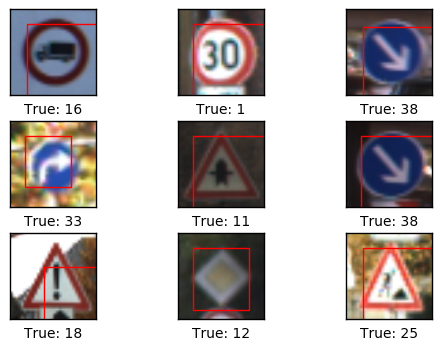

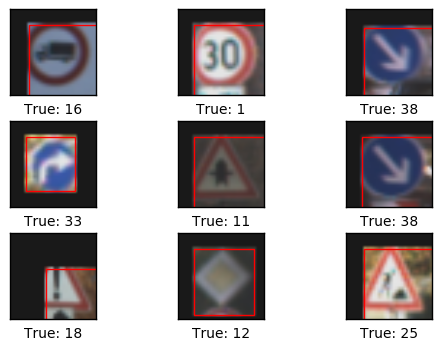

In [11]:
# Plot the TEST images and labels using our helper-function above.
print("Original Test Images -")
plot_images(images=test['features'][0:9], labels=test['labels'][0:9], cls_pred=None, rect_coords=test['coords'][0:9], reshape=False)

print("New Reshaped Test Images -")
plot_images(images=test['input-features'][0:9], labels=test['labels'][0:9], cls_pred=None, rect_coords=test['coords'][0:9], reshape=True)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [13]:
#img_size_flat = img_size * img_size
img_size_flat = 30 * 30 *3
num_classes = n_classes 
print(num_classes)

43


In [14]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

logits = tf.add(tf.matmul(x, weights),biases)
#weights2 = tf.Variable(tf.zeros([num_classes, num_classes]))
#biases2 = tf.Variable(tf.zeros([num_classes]))
keep_prob = tf.placeholder(tf.float32)
#hidden_layer = tf.add(tf.matmul(x, weights),biases)
#hidden_layer = tf.nn.relu(hidden_layer)
#hidden_layer = tf.nn.dropout(hidden_layer, keep_prob)
#logits = tf.add(tf.matmul(hidden_layer, weights2), biases2)

y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()
session.run(tf.initialize_all_variables())
batch_size = 100
batch_count = int(math.ceil(len(train['input-features'])/batch_size))

# Measurements use for graphing loss and accuracy
log_batch_step = 400
batches = []
loss_batch = []
train_acc_batch = []
train_full_acc_batch = []
valid_acc_batch = []

feed_dict_train_full = {x: train["input-features"],
                               y_true: train["hot-labels"],
                               y_true_cls: train["labels"],
                               keep_prob: 1}

def optimize(num_iterations):
    
    
    for i in range(num_iterations):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Iterations {:>2}/{}'.format(i+1, num_iterations), unit='batches')
        
        training_accuracy_local = -1
        training_accuracy_full = -1
        validation_accuracy = -1
    
        for batch_i in batches_pbar:
            # Get a batch of training examples.
            
            batch_start = batch_i*batch_size
            #print("batch_i=", batch_i, ",batch_start=", batch_start)
            batch_features = train["input-features"][batch_start:batch_start + batch_size]
            batch_labels = train["hot-labels"][batch_start:batch_start + batch_size]
            batch_labels_cls = train["labels"][batch_start:batch_start + batch_size]
            
            feed_dict_train = {x: batch_features,
                               y_true: batch_labels,
                               y_true_cls: batch_labels_cls,
                               keep_prob: 0.5}

            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            _, l = session.run([optimizer, cost],feed_dict=feed_dict_train)
            #print(batch_i % log_batch_step,", batches_pbar=",batches_pbar, ", batch_count=",batch_count, ",batch_start=", batch_start)
            
            # Log every 50 batches
            if (not batch_i % log_batch_step) or batch_i == len(batches_pbar):
                # Calculate Training and Validation accuracy
                training_accuracy_local = session.run(accuracy, feed_dict=feed_dict_train)
                #training_accuracy_full = session.run(accuracy, feed_dict=feed_dict_train_full)
                validation_accuracy = session.run(accuracy, feed_dict=feed_dict_test)
                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                #print("batch_i=", str(batch_i) ,  "training_accuracy_local=", str(training_accuracy_local),",Loss=" , str(l), ",training_accuracy_full=", str(training_accuracy_full),",validation_accuracy=", str(validation_accuracy), "batches Length=", str(len(batches)))
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy_local)
                #train_full_acc_batch.append(training_accuracy_full)
                valid_acc_batch.append(validation_accuracy)
        
        # Check accuracy against Validation data
        print( 
          " Training Accuracy Local=", str(training_accuracy_local),
          " Training Accuracy Full=", str(training_accuracy_full),
          " Validation Accuracy=", str(validation_accuracy),
              )

In [15]:
feed_dict_test = {x: test["input-features"],
                  y_true: test["hot-labels"],
                  y_true_cls: test["labels"],
                  keep_prob: 1}

In [32]:
def plot_accuracy():
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    #loss_plot.set_xlim([0, len(batches)])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    #acc_plot.plot(batches, train_full_acc_batch, 'g', label='Training Accuracy Full')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    
    acc_plot.set_ylim([0, 1.0])
    #acc_plot.set_xlim([batches[0], batches[-1]])
    #acc_plot.set_xlim([0, len(batches)])
    acc_plot.legend(loc=2)
    plt.tight_layout()
    plt.show()

In [17]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [18]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = feed_dict_test[y_true_cls]
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [19]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.array(feed_dict_test[x])[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = feed_dict_test[y_true_cls][incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9], labels=cls_true[0:9], cls_pred=cls_pred[0:9])
    #plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

In [20]:
def plot_example_success():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.array(feed_dict_test[x])[correct]
    images_len = len(images)
    # Get the predicted classes for those images.
    cls_pred = cls_pred[correct]

    # Get the true classes for those images.
    cls_true = feed_dict_test[y_true_cls][correct]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9], labels=cls_true[0:9], cls_pred=cls_pred[0:9])
    plot_images(images=images[images_len-9:images_len], 
                labels=cls_true[images_len-9:images_len], 
                cls_pred=cls_pred[images_len-9:images_len])

In [21]:
def plot_weights(weightTensor):
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weightTensor)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<num_classes:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, n_classes)
            image = w[:, i].reshape(30,30,3)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

Accuracy on test-set: 0.5%


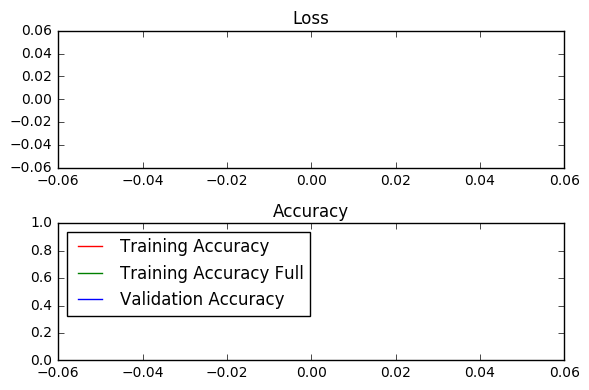

Plot Batches Length =  0


In [22]:
print_accuracy()
plot_accuracy()
print("Plot Batches Length = ", len(batches))

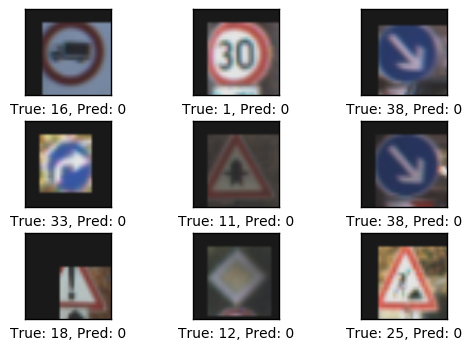

In [23]:
plot_example_errors()

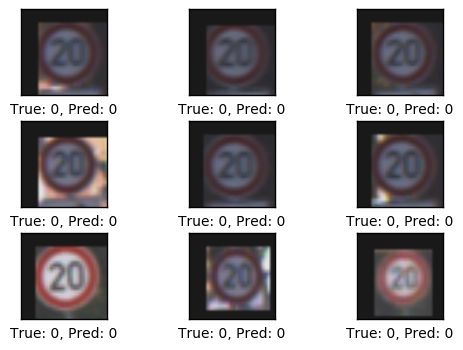

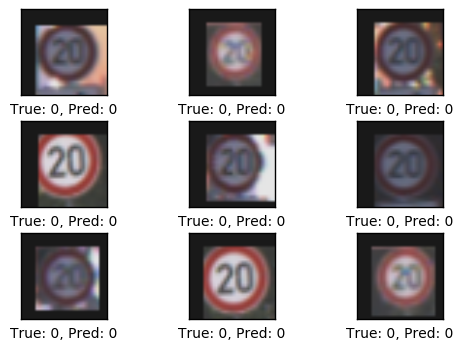

In [24]:
plot_example_success()

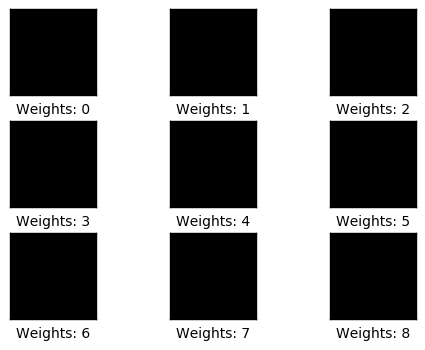

In [25]:
plot_weights(weights)

In [26]:
#plot_weights(weights2)

In [27]:
optimize(num_iterations=1)

Iterations  1/1: 100%|██████████| 393/393 [00:02<00:00, 177.20batches/s]

 Training Accuracy Local= 1.0  Training Accuracy Full= -1  Validation Accuracy= 0.00475059


Accuracy on test-set: 0.7%


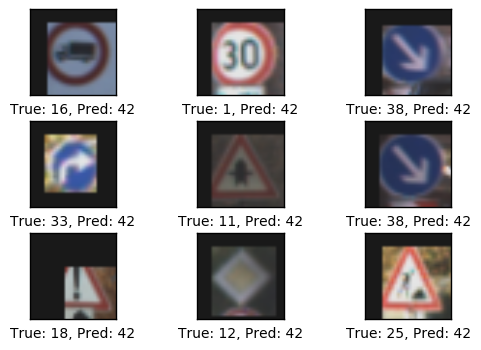

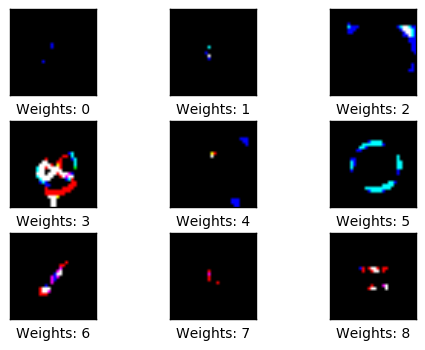

In [28]:
print_accuracy()
plot_example_errors()
plot_weights(weights)

Iterations  2/9:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.0  Training Accuracy Full= -1  Validation Accuracy= 0.00823436


Iterations  3/9:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.0  Training Accuracy Full= -1  Validation Accuracy= 0.0135392


Iterations  4/9:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.11  Training Accuracy Full= -1  Validation Accuracy= 0.0178939


Iterations  5/9:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.21  Training Accuracy Full= -1  Validation Accuracy= 0.0229612


Iterations  6/9:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.37  Training Accuracy Full= -1  Validation Accuracy= 0.031829


Iterations  7/9:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.52  Training Accuracy Full= -1  Validation Accuracy= 0.0376089


Iterations  8/9:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.57  Training Accuracy Full= -1  Validation Accuracy= 0.0448139


Iterations  9/9:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.6  Training Accuracy Full= -1  Validation Accuracy= 0.0520982


Iterations  9/9: 100%|██████████| 393/393 [00:01<00:00, 214.10batches/s]


 Training Accuracy Local= 0.63  Training Accuracy Full= -1  Validation Accuracy= 0.0601742
Accuracy on test-set: 3.4%


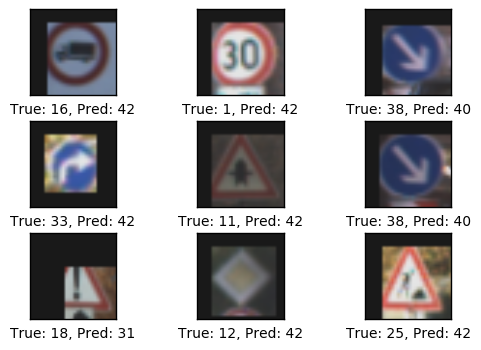

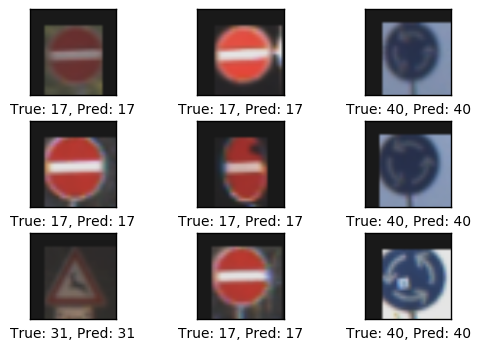

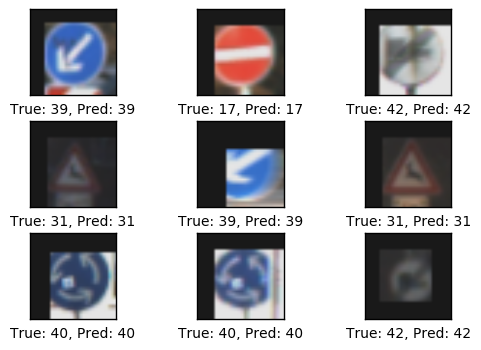

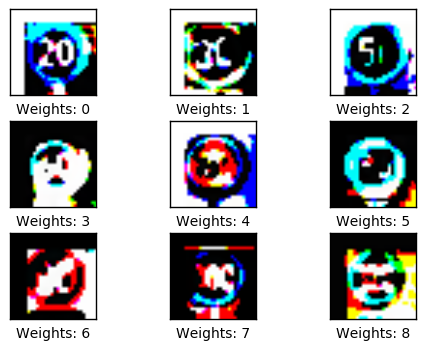

In [29]:
optimize(num_iterations=9)
print_accuracy()
plot_example_errors()
plot_example_success()
plot_weights(weights)

In [30]:
optimize(num_iterations=100)

Iterations  2/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.64  Training Accuracy Full= -1  Validation Accuracy= 0.0674584


Iterations  3/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.67  Training Accuracy Full= -1  Validation Accuracy= 0.0751386


Iterations  4/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.71  Training Accuracy Full= -1  Validation Accuracy= 0.0824228


Iterations  5/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.72  Training Accuracy Full= -1  Validation Accuracy= 0.0888361


Iterations  6/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.73  Training Accuracy Full= -1  Validation Accuracy= 0.0949327


Iterations  7/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.74  Training Accuracy Full= -1  Validation Accuracy= 0.100475


Iterations  8/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.78  Training Accuracy Full= -1  Validation Accuracy= 0.105622


Iterations  9/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.79  Training Accuracy Full= -1  Validation Accuracy= 0.109818


Iterations 10/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.8  Training Accuracy Full= -1  Validation Accuracy= 0.113935


Iterations 11/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.84  Training Accuracy Full= -1  Validation Accuracy= 0.117656


Iterations 12/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.84  Training Accuracy Full= -1  Validation Accuracy= 0.120982


Iterations 13/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.84  Training Accuracy Full= -1  Validation Accuracy= 0.124149


Iterations 14/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.85  Training Accuracy Full= -1  Validation Accuracy= 0.128028


Iterations 15/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.86  Training Accuracy Full= -1  Validation Accuracy= 0.131591


Iterations 16/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.86  Training Accuracy Full= -1  Validation Accuracy= 0.135629


Iterations 17/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.87  Training Accuracy Full= -1  Validation Accuracy= 0.141726


Iterations 18/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.88  Training Accuracy Full= -1  Validation Accuracy= 0.147823


Iterations 19/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.91  Training Accuracy Full= -1  Validation Accuracy= 0.153207


Iterations 20/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.91  Training Accuracy Full= -1  Validation Accuracy= 0.159541


Iterations 21/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.91  Training Accuracy Full= -1  Validation Accuracy= 0.165717


Iterations 22/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.91  Training Accuracy Full= -1  Validation Accuracy= 0.171576


Iterations 23/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.91  Training Accuracy Full= -1  Validation Accuracy= 0.17688


Iterations 24/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.91  Training Accuracy Full= -1  Validation Accuracy= 0.18274


Iterations 25/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.91  Training Accuracy Full= -1  Validation Accuracy= 0.188678


Iterations 26/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.92  Training Accuracy Full= -1  Validation Accuracy= 0.193428


Iterations 27/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.92  Training Accuracy Full= -1  Validation Accuracy= 0.198575


Iterations 28/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.92  Training Accuracy Full= -1  Validation Accuracy= 0.203088


Iterations 29/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.93  Training Accuracy Full= -1  Validation Accuracy= 0.208234


Iterations 30/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.93  Training Accuracy Full= -1  Validation Accuracy= 0.212035


Iterations 31/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.216865


Iterations 32/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.220744


Iterations 33/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.223753


Iterations 34/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.228345


Iterations 35/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.93  Training Accuracy Full= -1  Validation Accuracy= 0.231987


Iterations 36/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.93  Training Accuracy Full= -1  Validation Accuracy= 0.236263


Iterations 37/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.93  Training Accuracy Full= -1  Validation Accuracy= 0.240776


Iterations 38/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.93  Training Accuracy Full= -1  Validation Accuracy= 0.245289


Iterations 39/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.93  Training Accuracy Full= -1  Validation Accuracy= 0.249723


Iterations 40/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.93  Training Accuracy Full= -1  Validation Accuracy= 0.252811


Iterations 41/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.257165


Iterations 42/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.261045


Iterations 43/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.265717


Iterations 44/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.269913


Iterations 45/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.274268


Iterations 46/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.277831


Iterations 47/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.279889


Iterations 48/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.283056


Iterations 49/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.286619


Iterations 50/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.289549


Iterations 51/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.292795


Iterations 52/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.295962


Iterations 53/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.298416


Iterations 54/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.30095


Iterations 55/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.30388


Iterations 56/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.307284


Iterations 57/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.309422


Iterations 58/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.311956


Iterations 59/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.31441


Iterations 60/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.317023


Iterations 61/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.319477


Iterations 62/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.94  Training Accuracy Full= -1  Validation Accuracy= 0.322249


Iterations 63/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.323832


Iterations 64/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.32597


Iterations 65/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.328345


Iterations 66/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.330245


Iterations 67/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.331671


Iterations 68/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.333492


Iterations 69/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.336659


Iterations 70/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.337846


Iterations 71/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.340222


Iterations 72/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.342676


Iterations 73/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.344656


Iterations 74/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.347664


Iterations 75/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.350594


Iterations 76/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.352969


Iterations 77/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.355028


Iterations 78/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.357482


Iterations 79/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.359541


Iterations 80/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.361679


Iterations 81/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.363579


Iterations 82/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.366033


Iterations 83/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.368013


Iterations 84/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.369755


Iterations 85/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.371655


Iterations 86/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.373634


Iterations 87/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.374901


Iterations 88/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.376326


Iterations 89/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.378068


Iterations 90/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.379731


Iterations 91/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.380918


Iterations 92/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.382185


Iterations 93/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.383769


Iterations 94/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.385036


Iterations 95/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.386698


Iterations 96/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.388678


Iterations 97/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.390182


Iterations 98/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.39137


Iterations 99/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.392795


Iterations 100/100:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.393983


Iterations 100/100: 100%|██████████| 393/393 [00:02<00:00, 133.96batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.396041


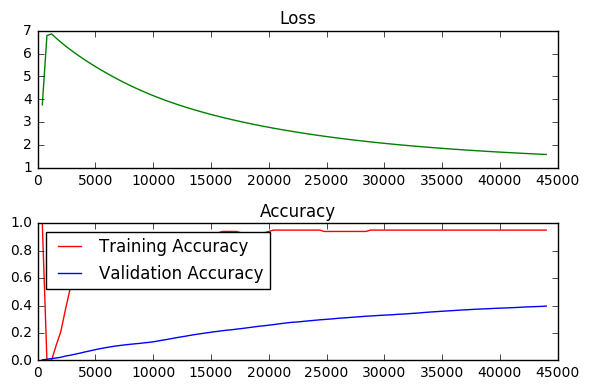

Accuracy on test-set: 40.5%


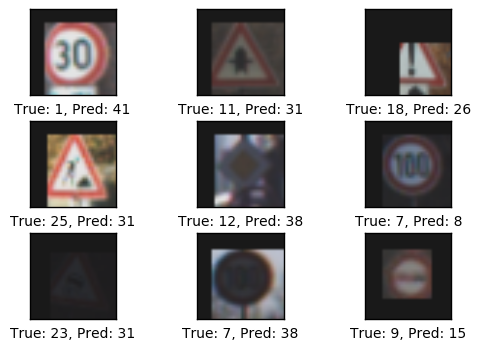

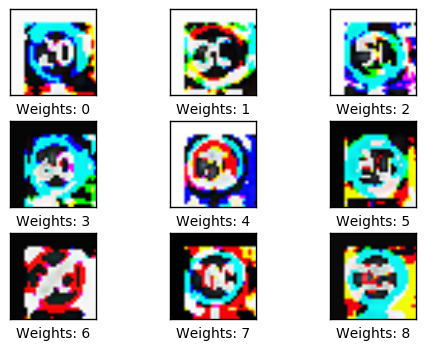

In [33]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_weights(weights)

[[ 14   1   1 ...,   1   0   0]
 [ 21  39  26 ...,  37  24   7]
 [ 11   0 106 ...,  19   3  32]
 ..., 
 [  0   0   0 ...,  76   0   2]
 [  0   0   0 ...,   0  24  22]
 [  0   0   0 ...,   0   1  82]]


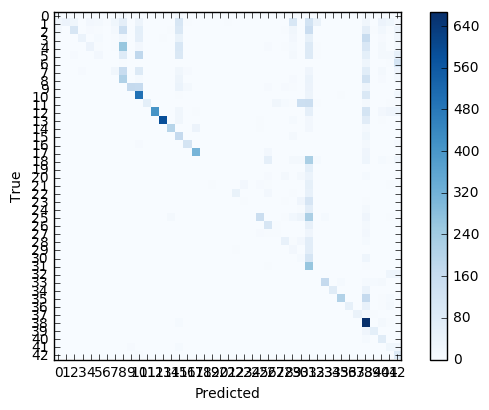

In [34]:
print_confusion_matrix()

In [35]:
optimize(num_iterations=200)

Iterations  2/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.398258


Iterations  3/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.399525


Iterations  4/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.401663


Iterations  5/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.403009


Iterations  6/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.404355


Iterations  7/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.405859


Iterations  8/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.407601


Iterations  9/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.408709


Iterations 10/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.409897


Iterations 11/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.411243


Iterations 12/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.411797


Iterations 13/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.413302


Iterations 14/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.414331


Iterations 15/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.415835


Iterations 16/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.417181


Iterations 17/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.418765


Iterations 18/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.419477


Iterations 19/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.420982


Iterations 20/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.421932


Iterations 21/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.42304


Iterations 22/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.42407


Iterations 23/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.42502


Iterations 24/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.426207


Iterations 25/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.427949


Iterations 26/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.429533


Iterations 27/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.431037


Iterations 28/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.432146


Iterations 29/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.433729


Iterations 30/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.434917


Iterations 31/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.436105


Iterations 32/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.437134


Iterations 33/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.438321


Iterations 34/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.439272


Iterations 35/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.440618


Iterations 36/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.441568


Iterations 37/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.442518


Iterations 38/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.443864


Iterations 39/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.444893


Iterations 40/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.445922


Iterations 41/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.446793


Iterations 42/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.447743


Iterations 43/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.448456


Iterations 44/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.44901


Iterations 45/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.45004


Iterations 46/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.451227


Iterations 47/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.452098


Iterations 48/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.452969


Iterations 49/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.454236


Iterations 50/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.455424


Iterations 51/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.456532


Iterations 52/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.457165


Iterations 53/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.458195


Iterations 54/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.459066


Iterations 55/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.460253


Iterations 56/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.460887


Iterations 57/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.462391


Iterations 58/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.463341


Iterations 59/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.463975


Iterations 60/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.465083


Iterations 61/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.465717


Iterations 62/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.466746


Iterations 63/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.467934


Iterations 64/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.468884


Iterations 65/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.469992


Iterations 66/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.470942


Iterations 67/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.472051


Iterations 68/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.472922


Iterations 69/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.473951


Iterations 70/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.474505


Iterations 71/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.475455


Iterations 72/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.476089


Iterations 73/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.477039


Iterations 74/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.47791


Iterations 75/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.478306


Iterations 76/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.479097


Iterations 77/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.479731


Iterations 78/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.480839


Iterations 79/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.481314


Iterations 80/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.482344


Iterations 81/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.483294


Iterations 82/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.484323


Iterations 83/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.485352


Iterations 84/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.486223


Iterations 85/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.487094


Iterations 86/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.488044


Iterations 87/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.488519


Iterations 88/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.489549


Iterations 89/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.490657


Iterations 90/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.491132


Iterations 91/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.491845


Iterations 92/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.492953


Iterations 93/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.493903


Iterations 94/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.494378


Iterations 95/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.495091


Iterations 96/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.495408


Iterations 97/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.496437


Iterations 98/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.497387


Iterations 99/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.497783


Iterations 100/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.498496


Iterations 101/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.49905


Iterations 102/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.499683


Iterations 103/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.500158


Iterations 104/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.500792


Iterations 105/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.501425


Iterations 106/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.502059


Iterations 107/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.502454


Iterations 108/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.503246


Iterations 109/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.504196


Iterations 110/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.50483


Iterations 111/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.50578


Iterations 112/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.506492


Iterations 113/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.507126


Iterations 114/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.508472


Iterations 115/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.509184


Iterations 116/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.509739


Iterations 117/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.510451


Iterations 118/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.511006


Iterations 119/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.511718


Iterations 120/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.512352


Iterations 121/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.513143


Iterations 122/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.513539


Iterations 123/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.514173


Iterations 124/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.514331


Iterations 125/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.514885


Iterations 126/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.515835


Iterations 127/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.516706


Iterations 128/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.517815


Iterations 129/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.519002


Iterations 130/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.519873


Iterations 131/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.52114


Iterations 132/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.521853


Iterations 133/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.522486


Iterations 134/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.52312


Iterations 135/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.523674


Iterations 136/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.524466


Iterations 137/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.525178


Iterations 138/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.526128


Iterations 139/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.526603


Iterations 140/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.527474


Iterations 141/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.528108


Iterations 142/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.528583


Iterations 143/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.529058


Iterations 144/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.529612


Iterations 145/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.530087


Iterations 146/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.530562


Iterations 147/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.531433


Iterations 148/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.531829


Iterations 149/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.532858


Iterations 150/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.533175


Iterations 151/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.533808


Iterations 152/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.534363


Iterations 153/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.535234


Iterations 154/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.535629


Iterations 155/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.5365


Iterations 156/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.537055


Iterations 157/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.537688


Iterations 158/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.538797


Iterations 159/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.539113


Iterations 160/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.53943


Iterations 161/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.540143


Iterations 162/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.540618


Iterations 163/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.541726


Iterations 164/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.54228


Iterations 165/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.543072


Iterations 166/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.54331


Iterations 167/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.544101


Iterations 168/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.544656


Iterations 169/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.544814


Iterations 170/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.545131


Iterations 171/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.545922


Iterations 172/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.546318


Iterations 173/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.546556


Iterations 174/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.547743


Iterations 175/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.548773


Iterations 176/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.549406


Iterations 177/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.550119


Iterations 178/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.550277


Iterations 179/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.551148


Iterations 180/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.551623


Iterations 181/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.552652


Iterations 182/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.552969


Iterations 183/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.553365


Iterations 184/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.554394


Iterations 185/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.554711


Iterations 186/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.555028


Iterations 187/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.555661


Iterations 188/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.556057


Iterations 189/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.556453


Iterations 190/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.557245


Iterations 191/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.55772


Iterations 192/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.557957


Iterations 193/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.558749


Iterations 194/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.559145


Iterations 195/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.559382


Iterations 196/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.559937


Iterations 197/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.560253


Iterations 198/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.560808


Iterations 199/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.561362


Iterations 200/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.561837


Iterations 200/200: 100%|██████████| 393/393 [00:01<00:00, 202.83batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.562549


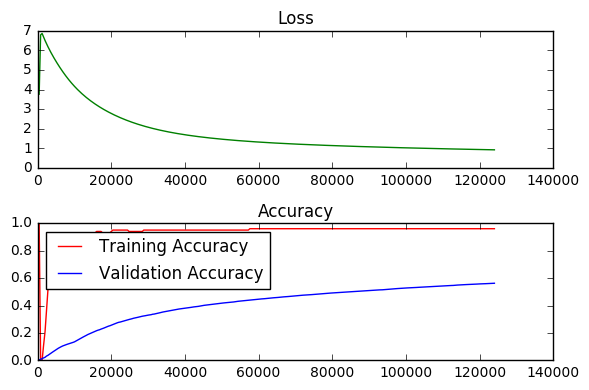

Accuracy on test-set: 56.8%
[[  5   4   1 ...,   0   0   0]
 [ 21 144  34 ...,   2   0   2]
 [  9   2 212 ...,   4   0   0]
 ..., 
 [  0   0   0 ...,  73   0   0]
 [  0   0   0 ...,   0  38   6]
 [  0   0   0 ...,   0   1  82]]


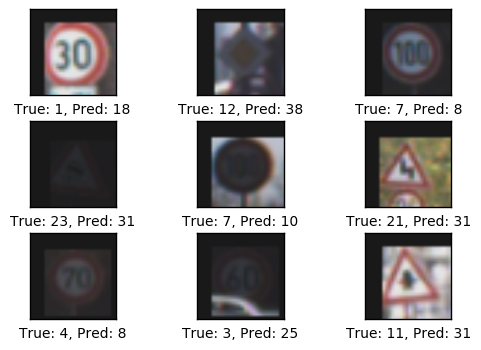

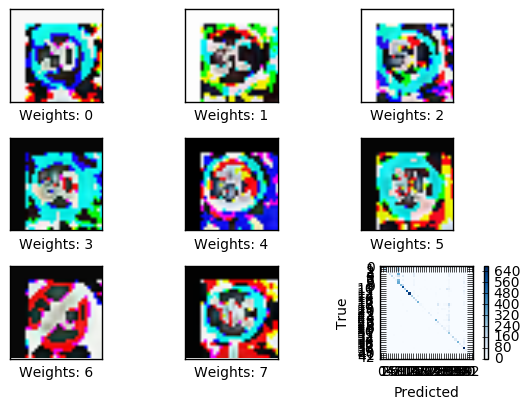

In [36]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_weights(weights)

In [37]:
optimize(num_iterations=200)

Iterations  2/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.563025


Iterations  3/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.5635


Iterations  4/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.563975


Iterations  5/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.564766


Iterations  6/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.565004


Iterations  7/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.565796


Iterations  8/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.566746


Iterations  9/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.567775


Iterations 10/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.568171


Iterations 11/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.568488


Iterations 12/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.5692


Iterations 13/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.569675


Iterations 14/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.57015


Iterations 15/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.570942


Iterations 16/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.571338


Iterations 17/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.571734


Iterations 18/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.572288


Iterations 19/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.572526


Iterations 20/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.573238


Iterations 21/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.573634


Iterations 22/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.574109


Iterations 23/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.574505


Iterations 24/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.574822


Iterations 25/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.575455


Iterations 26/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.575693


Iterations 27/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.576326


Iterations 28/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.57688


Iterations 29/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.577356


Iterations 30/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.577672


Iterations 31/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.578068


Iterations 32/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.578306


Iterations 33/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.578543


Iterations 34/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.579097


Iterations 35/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.57981


Iterations 36/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.579889


Iterations 37/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.580364


Iterations 38/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.580681


Iterations 39/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.581552


Iterations 40/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.582185


Iterations 41/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.582581


Iterations 42/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.583215


Iterations 43/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.58369


Iterations 44/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.584086


Iterations 45/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.584165


Iterations 46/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.584481


Iterations 47/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.584798


Iterations 48/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.585273


Iterations 49/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.585511


Iterations 50/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.585986


Iterations 51/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.586065


Iterations 52/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.586223


Iterations 53/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.586936


Iterations 54/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.587411


Iterations 55/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.587807


Iterations 56/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.588124


Iterations 57/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.588361


Iterations 58/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.588915


Iterations 59/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.58939


Iterations 60/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.589945


Iterations 61/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.590182


Iterations 62/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.590736


Iterations 63/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.591132


Iterations 64/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.59137


Iterations 65/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.591845


Iterations 66/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.592162


Iterations 67/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.592478


Iterations 68/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.592874


Iterations 69/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.593112


Iterations 70/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.593428


Iterations 71/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.593587


Iterations 72/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.593983


Iterations 73/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.594616


Iterations 74/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.594774


Iterations 75/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.595012


Iterations 76/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.595091


Iterations 77/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.595487


Iterations 78/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.5962


Iterations 79/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.596595


Iterations 80/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.597229


Iterations 81/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.597546


Iterations 82/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.597862


Iterations 83/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.5981


Iterations 84/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.598337


Iterations 85/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.598812


Iterations 86/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.599129


Iterations 87/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.599683


Iterations 88/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.600238


Iterations 89/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.600713


Iterations 90/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.601029


Iterations 91/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.601504


Iterations 92/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.601979


Iterations 93/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.602375


Iterations 94/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.60285


Iterations 95/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.603167


Iterations 96/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.603484


Iterations 97/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.603642


Iterations 98/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.6038


Iterations 99/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.604117


Iterations 100/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.604434


Iterations 101/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.604909


Iterations 102/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.605226


Iterations 103/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.605622


Iterations 104/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.605938


Iterations 105/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.606176


Iterations 106/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.606572


Iterations 107/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.607284


Iterations 108/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.607759


Iterations 109/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.608076


Iterations 110/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.608314


Iterations 111/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.608868


Iterations 112/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.609105


Iterations 113/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.609818


Iterations 114/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.610451


Iterations 115/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.610689


Iterations 116/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.610926


Iterations 117/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.611243


Iterations 118/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.611322


Iterations 119/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.611481


Iterations 120/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.612193


Iterations 121/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.612827


Iterations 122/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.613222


Iterations 123/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.613698


Iterations 124/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.614093


Iterations 125/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.61441


Iterations 126/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.614489


Iterations 127/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.614885


Iterations 128/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.614964


Iterations 129/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.615439


Iterations 130/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.615677


Iterations 131/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.615994


Iterations 132/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.61631


Iterations 133/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.616548


Iterations 134/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.616865


Iterations 135/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.617102


Iterations 136/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.617419


Iterations 137/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.617656


Iterations 138/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.617894


Iterations 139/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.618052


Iterations 140/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.618527


Iterations 141/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.618923


Iterations 142/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.619082


Iterations 143/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.619161


Iterations 144/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.619161


Iterations 145/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.619557


Iterations 146/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.620111


Iterations 147/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.62019


Iterations 148/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.620586


Iterations 149/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.621298


Iterations 150/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.621694


Iterations 151/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.622011


Iterations 152/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.622169


Iterations 153/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.622486


Iterations 154/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.622803


Iterations 155/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.623199


Iterations 156/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.623515


Iterations 157/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.623911


Iterations 158/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.624545


Iterations 159/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.624703


Iterations 160/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.624941


Iterations 161/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.625416


Iterations 162/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.625812


Iterations 163/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.626207


Iterations 164/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.626287


Iterations 165/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.626603


Iterations 166/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.62692


Iterations 167/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.627553


Iterations 168/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.628108


Iterations 169/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.628266


Iterations 170/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.628266


Iterations 171/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.628424


Iterations 172/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.628979


Iterations 173/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.629295


Iterations 174/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.629533


Iterations 175/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.62977


Iterations 176/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.629691


Iterations 177/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.630087


Iterations 178/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.630641


Iterations 179/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.631037


Iterations 180/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.631037


Iterations 181/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.631196


Iterations 182/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.631354


Iterations 183/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.63175


Iterations 184/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.631987


Iterations 185/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.632225


Iterations 186/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.632462


Iterations 187/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.632621


Iterations 188/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.633017


Iterations 189/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.633729


Iterations 190/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.634283


Iterations 191/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.634442


Iterations 192/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.634521


Iterations 193/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.634838


Iterations 194/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.635313


Iterations 195/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.635629


Iterations 196/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.635867


Iterations 197/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.635946


Iterations 198/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.636263


Iterations 199/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.63658


Iterations 200/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.637134


Iterations 200/200: 100%|██████████| 393/393 [00:01<00:00, 212.99batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.63753


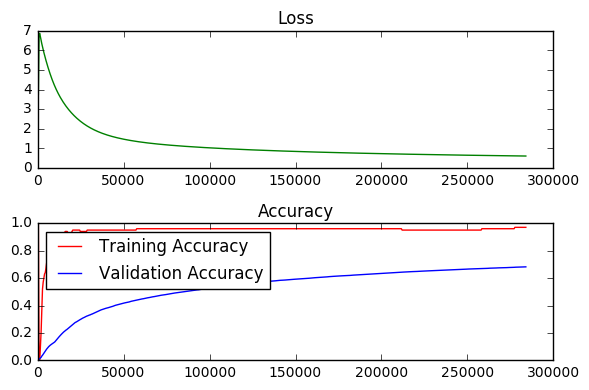

Accuracy on test-set: 68.3%


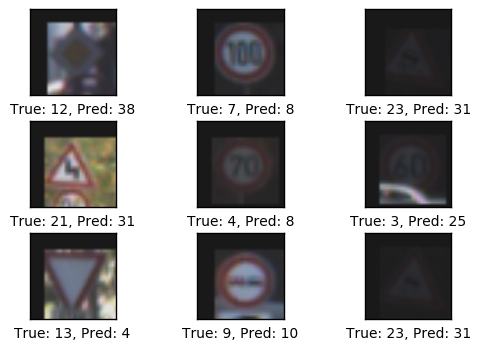

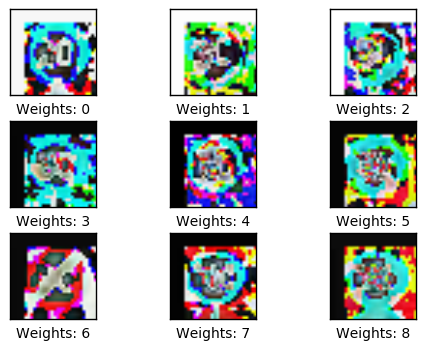

In [42]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_weights(weights)

In [39]:
optimize(num_iterations=200)

Iterations  2/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.638242


Iterations  3/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.638638


Iterations  4/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.638876


Iterations  5/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.639113


Iterations  6/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.639351


Iterations  7/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.639588


Iterations  8/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.639667


Iterations  9/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.639905


Iterations 10/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.640063


Iterations 11/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.640222


Iterations 12/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.640538


Iterations 13/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.640776


Iterations 14/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.641409


Iterations 15/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.641805


Iterations 16/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.641884


Iterations 17/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.642122


Iterations 18/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.642359


Iterations 19/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.642597


Iterations 20/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.642755


Iterations 21/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.643072


Iterations 22/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.643547


Iterations 23/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.643943


Iterations 24/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.64426


Iterations 25/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.644735


Iterations 26/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.645051


Iterations 27/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.645289


Iterations 28/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.645527


Iterations 29/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.646081


Iterations 30/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.646081


Iterations 31/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.64616


Iterations 32/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.646239


Iterations 33/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.646397


Iterations 34/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.646635


Iterations 35/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.647031


Iterations 36/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.647348


Iterations 37/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.647427


Iterations 38/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.647585


Iterations 39/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.647902


Iterations 40/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.647902


Iterations 41/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.648219


Iterations 42/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.648535


Iterations 43/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.648694


Iterations 44/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.649089


Iterations 45/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.649485


Iterations 46/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.649565


Iterations 47/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.649802


Iterations 48/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.650119


Iterations 49/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.650435


Iterations 50/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.650594


Iterations 51/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.650752


Iterations 52/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.651069


Iterations 53/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.651544


Iterations 54/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.651781


Iterations 55/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.652098


Iterations 56/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.652336


Iterations 57/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.652257


Iterations 58/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.652652


Iterations 59/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.652811


Iterations 60/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.653048


Iterations 61/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.653286


Iterations 62/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.653365


Iterations 63/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.653761


Iterations 64/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.654157


Iterations 65/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.654315


Iterations 66/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.654473


Iterations 67/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.654632


Iterations 68/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.65479


Iterations 69/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.655186


Iterations 70/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.655661


Iterations 71/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.65574


Iterations 72/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.655978


Iterations 73/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.656374


Iterations 74/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.656453


Iterations 75/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.656928


Iterations 76/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.657007


Iterations 77/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.657086


Iterations 78/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.657245


Iterations 79/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.657641


Iterations 80/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.657641


Iterations 81/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.657878


Iterations 82/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.657878


Iterations 83/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.658116


Iterations 84/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.658353


Iterations 85/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.658353


Iterations 86/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.65867


Iterations 87/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.659303


Iterations 88/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.659699


Iterations 89/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.659937


Iterations 90/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.660491


Iterations 91/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.660649


Iterations 92/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.660887


Iterations 93/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.661124


Iterations 94/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.661441


Iterations 95/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.66152


Iterations 96/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.661758


Iterations 97/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.661916


Iterations 98/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.662074


Iterations 99/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.662391


Iterations 100/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.662391


Iterations 101/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.66247


Iterations 102/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.662945


Iterations 103/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.663262


Iterations 104/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.66342


Iterations 105/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.663658


Iterations 106/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.663895


Iterations 107/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.664133


Iterations 108/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.664291


Iterations 109/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.664608


Iterations 110/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.664766


Iterations 111/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.664925


Iterations 112/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.664925


Iterations 113/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.665162


Iterations 114/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.665162


Iterations 115/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.665241


Iterations 116/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.665717


Iterations 117/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.665954


Iterations 118/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.666271


Iterations 119/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.666429


Iterations 120/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.666508


Iterations 121/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.666825


Iterations 122/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.667063


Iterations 123/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.667221


Iterations 124/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.667221


Iterations 125/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.6673


Iterations 126/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.667458


Iterations 127/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.667617


Iterations 128/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.667933


Iterations 129/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.668013


Iterations 130/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.667933


Iterations 131/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.668092


Iterations 132/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.668409


Iterations 133/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.668646


Iterations 134/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.668804


Iterations 135/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.668884


Iterations 136/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.95  Training Accuracy Full= -1  Validation Accuracy= 0.6692


Iterations 137/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.669359


Iterations 138/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.669517


Iterations 139/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.669675


Iterations 140/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.669913


Iterations 141/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.67015


Iterations 142/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.670467


Iterations 143/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.670467


Iterations 144/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.670705


Iterations 145/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.671101


Iterations 146/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.671576


Iterations 147/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.671971


Iterations 148/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.67213


Iterations 149/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.672367


Iterations 150/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.672605


Iterations 151/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.672842


Iterations 152/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.672922


Iterations 153/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.673001


Iterations 154/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.67308


Iterations 155/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.673159


Iterations 156/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.673317


Iterations 157/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.673555


Iterations 158/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.673872


Iterations 159/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.673872


Iterations 160/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.674188


Iterations 161/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.674663


Iterations 162/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.674743


Iterations 163/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.674743


Iterations 164/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.674901


Iterations 165/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.675139


Iterations 166/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.675139


Iterations 167/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.675139


Iterations 168/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.675534


Iterations 169/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.675772


Iterations 170/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.675851


Iterations 171/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.676089


Iterations 172/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.676326


Iterations 173/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.676405


Iterations 174/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.676801


Iterations 175/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.67696


Iterations 176/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.677197


Iterations 177/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.677435


Iterations 178/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.677514


Iterations 179/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.677593


Iterations 180/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.677751


Iterations 181/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.677989


Iterations 182/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.678068


Iterations 183/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.678385


Iterations 184/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.96  Training Accuracy Full= -1  Validation Accuracy= 0.678702


Iterations 185/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.679414


Iterations 186/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.679493


Iterations 187/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.679652


Iterations 188/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.679889


Iterations 189/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.680206


Iterations 190/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.680206


Iterations 191/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.680364


Iterations 192/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.680523


Iterations 193/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.680523


Iterations 194/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.680681


Iterations 195/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.68076


Iterations 196/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.680998


Iterations 197/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.681077


Iterations 198/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.681394


Iterations 199/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.681552


Iterations 200/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.681789


Iterations 200/200: 100%|██████████| 393/393 [00:01<00:00, 207.89batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.682027


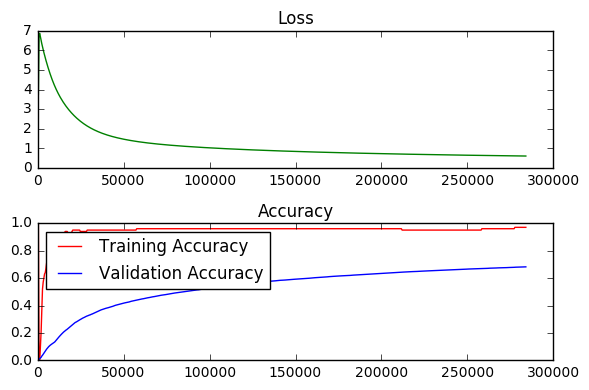

Accuracy on test-set: 68.3%
[[ 10   8   1 ...,   0   0   0]
 [ 20 273  42 ...,   0   0   1]
 [  7   1 316 ...,   1   0   0]
 ..., 
 [  0   0   0 ...,  77   0   0]
 [  0   0   0 ...,   0  42   2]
 [  0   0   0 ...,   0   2  77]]


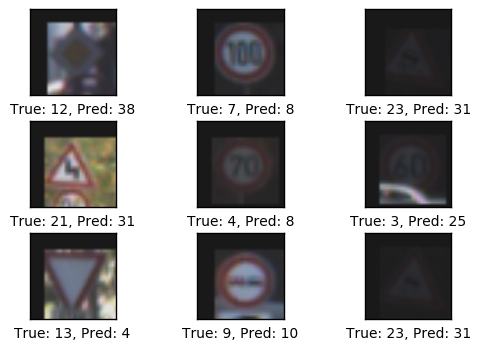

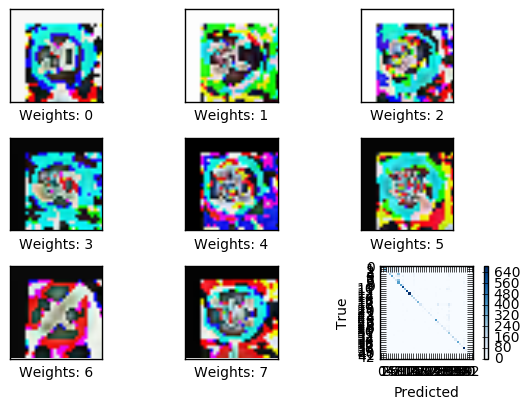

In [40]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_weights(weights)
print_confusion_matrix()

In [43]:
optimize(num_iterations=200)

Iterations  2/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.681948


Iterations  3/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.682027


Iterations  4/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.682264


Iterations  5/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.682502


Iterations  6/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.682581


Iterations  7/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.68266


Iterations  8/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.682819


Iterations  9/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.682898


Iterations 10/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.682898


Iterations 11/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.682898


Iterations 12/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.683056


Iterations 13/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.683135


Iterations 14/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.683294


Iterations 15/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.683294


Iterations 16/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.683531


Iterations 17/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.68361


Iterations 18/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.68361


Iterations 19/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.68369


Iterations 20/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.683848


Iterations 21/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.683848


Iterations 22/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.683927


Iterations 23/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.684244


Iterations 24/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.684561


Iterations 25/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.684719


Iterations 26/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.685036


Iterations 27/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.685273


Iterations 28/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.68559


Iterations 29/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.685827


Iterations 30/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.686223


Iterations 31/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.686461


Iterations 32/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.686619


Iterations 33/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.686778


Iterations 34/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.686778


Iterations 35/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.686857


Iterations 36/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.686936


Iterations 37/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.687015


Iterations 38/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.687094


Iterations 39/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.687173


Iterations 40/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.687411


Iterations 41/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.68749


Iterations 42/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.687569


Iterations 43/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.687728


Iterations 44/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.688044


Iterations 45/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.688124


Iterations 46/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.688282


Iterations 47/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.68844


Iterations 48/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.688519


Iterations 49/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.688678


Iterations 50/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.688836


Iterations 51/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.688994


Iterations 52/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.688994


Iterations 53/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.689153


Iterations 54/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.689232


Iterations 55/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.68939


Iterations 56/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.689628


Iterations 57/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.689707


Iterations 58/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.689786


Iterations 59/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.689865


Iterations 60/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.689945


Iterations 61/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.690182


Iterations 62/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.69042


Iterations 63/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.690895


Iterations 64/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.691053


Iterations 65/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.691291


Iterations 66/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.691607


Iterations 67/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.691686


Iterations 68/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.691924


Iterations 69/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.69232


Iterations 70/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.692557


Iterations 71/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.692637


Iterations 72/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.693032


Iterations 73/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.693032


Iterations 74/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.693112


Iterations 75/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.693112


Iterations 76/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.693349


Iterations 77/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.693349


Iterations 78/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.693507


Iterations 79/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.693903


Iterations 80/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.694141


Iterations 81/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.694299


Iterations 82/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.694458


Iterations 83/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.694616


Iterations 84/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.694774


Iterations 85/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.694933


Iterations 86/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.695091


Iterations 87/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.69517


Iterations 88/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.695329


Iterations 89/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.695487


Iterations 90/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.695804


Iterations 91/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.695883


Iterations 92/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.69612


Iterations 93/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.69612


Iterations 94/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.696279


Iterations 95/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.696437


Iterations 96/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.696437


Iterations 97/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.696675


Iterations 98/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.696833


Iterations 99/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.696912


Iterations 100/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.69715


Iterations 101/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.697308


Iterations 102/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.697546


Iterations 103/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.697783


Iterations 104/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.697941


Iterations 105/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.698179


Iterations 106/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.698496


Iterations 107/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.698416


Iterations 108/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.698575


Iterations 109/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.698654


Iterations 110/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.698654


Iterations 111/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.69905


Iterations 112/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.699129


Iterations 113/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.699208


Iterations 114/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.699525


Iterations 115/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.699604


Iterations 116/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.699604


Iterations 117/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.699604


Iterations 118/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.699604


Iterations 119/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.699921


Iterations 120/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.700317


Iterations 121/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.700554


Iterations 122/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.700633


Iterations 123/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.700713


Iterations 124/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.700871


Iterations 125/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.700792


Iterations 126/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.701029


Iterations 127/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.701188


Iterations 128/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.701425


Iterations 129/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.701663


Iterations 130/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.701742


Iterations 131/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.7019


Iterations 132/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.702059


Iterations 133/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.702059


Iterations 134/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.702138


Iterations 135/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.702217


Iterations 136/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.702296


Iterations 137/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.702375


Iterations 138/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.702534


Iterations 139/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.702692


Iterations 140/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.702771


Iterations 141/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.703009


Iterations 142/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.703088


Iterations 143/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.703325


Iterations 144/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.703484


Iterations 145/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.703484


Iterations 146/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.703484


Iterations 147/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.703325


Iterations 148/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.703484


Iterations 149/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.7038


Iterations 150/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.7038


Iterations 151/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.703959


Iterations 152/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.704117


Iterations 153/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.704117


Iterations 154/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.704117


Iterations 155/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.704434


Iterations 156/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.704513


Iterations 157/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.70483


Iterations 158/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.705146


Iterations 159/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.705226


Iterations 160/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.705384


Iterations 161/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.705622


Iterations 162/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.705938


Iterations 163/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.706017


Iterations 164/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.706097


Iterations 165/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.706255


Iterations 166/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.706334


Iterations 167/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.706572


Iterations 168/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.706809


Iterations 169/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.706888


Iterations 170/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.706968


Iterations 171/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.707126


Iterations 172/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.707205


Iterations 173/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.707363


Iterations 174/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.707443


Iterations 175/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.707601


Iterations 176/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.707918


Iterations 177/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.708234


Iterations 178/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.708234


Iterations 179/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.708393


Iterations 180/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.708709


Iterations 181/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.708947


Iterations 182/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.709264


Iterations 183/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.709422


Iterations 184/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.709501


Iterations 185/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.70966


Iterations 186/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.709818


Iterations 187/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.709818


Iterations 188/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.710214


Iterations 189/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.710451


Iterations 190/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.71061


Iterations 191/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.710768


Iterations 192/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.710926


Iterations 193/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.711006


Iterations 194/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.711085


Iterations 195/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.711164


Iterations 196/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.711243


Iterations 197/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.711322


Iterations 198/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.711481


Iterations 199/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.711639


Iterations 200/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.711877


Iterations 200/200: 100%|██████████| 393/393 [00:01<00:00, 205.67batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.712035


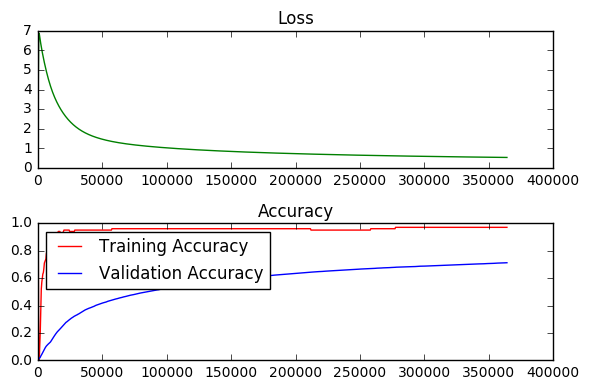

Accuracy on test-set: 71.2%
[[ 11  12   1 ...,   0   0   0]
 [ 22 307  45 ...,   0   0   1]
 [  7   2 364 ...,   2   0   0]
 ..., 
 [  0   0   0 ...,  76   0   0]
 [  0   0   0 ...,   0  43   2]
 [  0   0   0 ...,   0   2  74]]


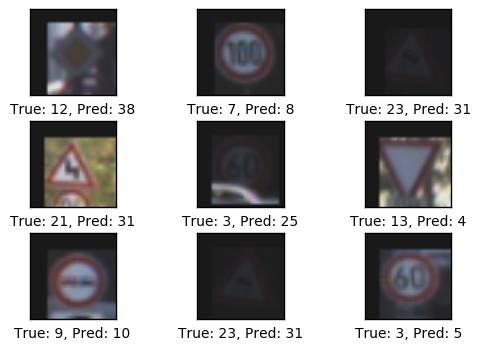

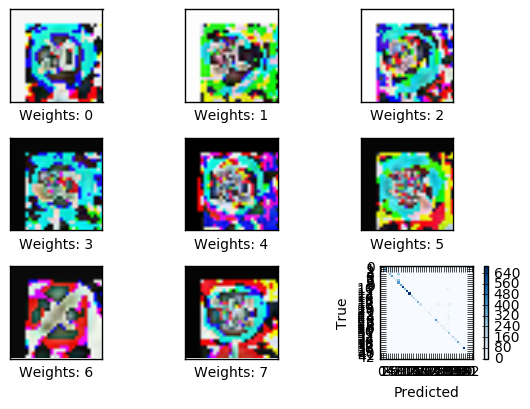

In [44]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_weights(weights)
print_confusion_matrix()

In [45]:
optimize(num_iterations=200)

Iterations  2/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.712035


Iterations  3/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.712272


Iterations  4/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.712352


Iterations  5/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.712352


Iterations  6/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.712352


Iterations  7/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.71251


Iterations  8/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.71251


Iterations  9/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.712589


Iterations 10/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.712668


Iterations 11/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713064


Iterations 12/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713223


Iterations 13/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713381


Iterations 14/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713539


Iterations 15/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713698


Iterations 16/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713777


Iterations 17/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713777


Iterations 18/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713777


Iterations 19/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713856


Iterations 20/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.713935


Iterations 21/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.714093


Iterations 22/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.714252


Iterations 23/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.714331


Iterations 24/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.714648


Iterations 25/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.714806


Iterations 26/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.714885


Iterations 27/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715044


Iterations 28/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715123


Iterations 29/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715123


Iterations 30/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715202


Iterations 31/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715281


Iterations 32/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715519


Iterations 33/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715598


Iterations 34/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715756


Iterations 35/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715835


Iterations 36/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.715994


Iterations 37/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.716073


Iterations 38/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.716152


Iterations 39/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.71631


Iterations 40/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.716548


Iterations 41/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.716706


Iterations 42/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.717023


Iterations 43/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.71726


Iterations 44/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.71734


Iterations 45/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.71734


Iterations 46/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.717419


Iterations 47/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.717419


Iterations 48/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.717577


Iterations 49/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.717815


Iterations 50/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.717815


Iterations 51/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.717815


Iterations 52/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.717815


Iterations 53/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.717894


Iterations 54/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718052


Iterations 55/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718052


Iterations 56/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718052


Iterations 57/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718052


Iterations 58/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718052


Iterations 59/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718131


Iterations 60/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.71829


Iterations 61/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718448


Iterations 62/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718527


Iterations 63/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718527


Iterations 64/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718606


Iterations 65/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718765


Iterations 66/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.718844


Iterations 67/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.719082


Iterations 68/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.71924


Iterations 69/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.719477


Iterations 70/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.719636


Iterations 71/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.719636


Iterations 72/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.719715


Iterations 73/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.719794


Iterations 74/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.719953


Iterations 75/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.719953


Iterations 76/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.720032


Iterations 77/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.720111


Iterations 78/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.720111


Iterations 79/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.720269


Iterations 80/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.720428


Iterations 81/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.720665


Iterations 82/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.720903


Iterations 83/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.720903


Iterations 84/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.720982


Iterations 85/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.721061


Iterations 86/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72114


Iterations 87/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.721299


Iterations 88/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.721536


Iterations 89/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.721615


Iterations 90/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.721774


Iterations 91/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.721932


Iterations 92/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722011


Iterations 93/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72209


Iterations 94/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722249


Iterations 95/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722249


Iterations 96/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722328


Iterations 97/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722407


Iterations 98/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722407


Iterations 99/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722407


Iterations 100/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722645


Iterations 101/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722565


Iterations 102/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722645


Iterations 103/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722803


Iterations 104/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.722882


Iterations 105/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72304


Iterations 106/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.723199


Iterations 107/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.723278


Iterations 108/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.723357


Iterations 109/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.723357


Iterations 110/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.723436


Iterations 111/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.723595


Iterations 112/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.723911


Iterations 113/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72399


Iterations 114/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72407


Iterations 115/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72407


Iterations 116/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.724228


Iterations 117/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.724228


Iterations 118/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.724466


Iterations 119/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.724545


Iterations 120/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.724782


Iterations 121/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.724941


Iterations 122/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.724941


Iterations 123/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.725416


Iterations 124/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.725495


Iterations 125/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.725653


Iterations 126/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.725653


Iterations 127/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.725653


Iterations 128/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.725732


Iterations 129/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.725812


Iterations 130/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72597


Iterations 131/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72597


Iterations 132/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.726049


Iterations 133/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.726128


Iterations 134/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.726287


Iterations 135/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.726366


Iterations 136/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.726524


Iterations 137/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.726603


Iterations 138/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.726841


Iterations 139/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.726841


Iterations 140/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72692


Iterations 141/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.726999


Iterations 142/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727158


Iterations 143/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727158


Iterations 144/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727158


Iterations 145/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727316


Iterations 146/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727237


Iterations 147/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727474


Iterations 148/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727553


Iterations 149/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727633


Iterations 150/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727712


Iterations 151/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72787


Iterations 152/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.727949


Iterations 153/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728028


Iterations 154/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728187


Iterations 155/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728187


Iterations 156/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728187


Iterations 157/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728108


Iterations 158/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728266


Iterations 159/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728345


Iterations 160/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728424


Iterations 161/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728583


Iterations 162/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728741


Iterations 163/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.728979


Iterations 164/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.729058


Iterations 165/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.729137


Iterations 166/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.729137


Iterations 167/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.729295


Iterations 168/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.729612


Iterations 169/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.72977


Iterations 170/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.730087


Iterations 171/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.730245


Iterations 172/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.730483


Iterations 173/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.730404


Iterations 174/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.730562


Iterations 175/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.730641


Iterations 176/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.730879


Iterations 177/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731196


Iterations 178/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731275


Iterations 179/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731433


Iterations 180/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731512


Iterations 181/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731671


Iterations 182/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731829


Iterations 183/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731829


Iterations 184/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.732067


Iterations 185/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731987


Iterations 186/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731987


Iterations 187/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.731987


Iterations 188/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.732067


Iterations 189/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.732146


Iterations 190/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.732304


Iterations 191/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.732383


Iterations 192/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.732462


Iterations 193/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.732858


Iterations 194/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.732937


Iterations 195/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.733017


Iterations 196/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.733175


Iterations 197/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.733413


Iterations 198/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.733571


Iterations 199/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.733967


Iterations 200/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.734204


Iterations 200/200: 100%|██████████| 393/393 [00:01<00:00, 208.52batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.734363


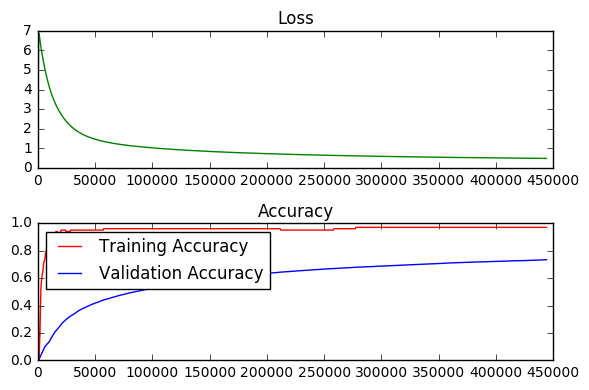

Accuracy on test-set: 73.5%


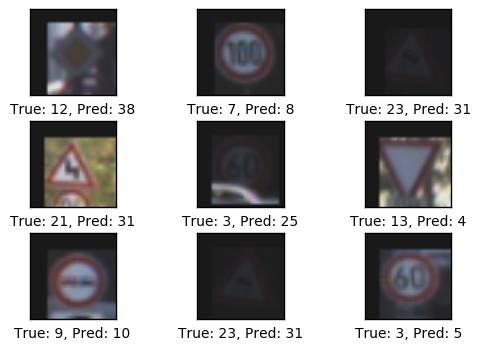

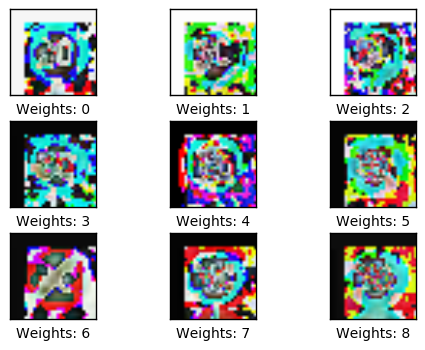

In [46]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_weights(weights)

In [47]:
optimize(num_iterations=200)

Iterations  2/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.734521


Iterations  3/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.7346


Iterations  4/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.734758


Iterations  5/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.734996


Iterations  6/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735075


Iterations  7/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735075


Iterations  8/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735075


Iterations  9/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735154


Iterations 10/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735154


Iterations 11/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735154


Iterations 12/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735234


Iterations 13/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735234


Iterations 14/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735234


Iterations 15/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735629


Iterations 16/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735709


Iterations 17/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.735629


Iterations 18/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.736025


Iterations 19/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.736184


Iterations 20/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.736104


Iterations 21/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.736342


Iterations 22/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.736263


Iterations 23/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.736263


Iterations 24/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.73658


Iterations 25/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.73658


Iterations 26/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.736738


Iterations 27/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.736817


Iterations 28/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.736817


Iterations 29/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.737134


Iterations 30/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.737292


Iterations 31/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.73753


Iterations 32/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.737688


Iterations 33/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.737688


Iterations 34/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.737767


Iterations 35/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.737767


Iterations 36/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.737926


Iterations 37/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738005


Iterations 38/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738005


Iterations 39/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738084


Iterations 40/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738321


Iterations 41/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.73848


Iterations 42/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738638


Iterations 43/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738797


Iterations 44/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738797


Iterations 45/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738876


Iterations 46/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738876


Iterations 47/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738955


Iterations 48/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.738955


Iterations 49/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739113


Iterations 50/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739272


Iterations 51/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739272


Iterations 52/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739272


Iterations 53/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.73943


Iterations 54/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739509


Iterations 55/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739588


Iterations 56/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739667


Iterations 57/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739826


Iterations 58/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739905


Iterations 59/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.739984


Iterations 60/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.740222


Iterations 61/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.740222


Iterations 62/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.740222


Iterations 63/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.740301


Iterations 64/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74038


Iterations 65/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.740459


Iterations 66/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.740618


Iterations 67/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.740776


Iterations 68/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.740934


Iterations 69/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.740934


Iterations 70/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741093


Iterations 71/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741172


Iterations 72/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741172


Iterations 73/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741251


Iterations 74/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741251


Iterations 75/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74133


Iterations 76/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741409


Iterations 77/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741489


Iterations 78/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741568


Iterations 79/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741568


Iterations 80/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741805


Iterations 81/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.741805


Iterations 82/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742043


Iterations 83/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742043


Iterations 84/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742122


Iterations 85/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742201


Iterations 86/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74228


Iterations 87/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74228


Iterations 88/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742359


Iterations 89/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742439


Iterations 90/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742439


Iterations 91/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742597


Iterations 92/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742755


Iterations 93/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742676


Iterations 94/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742755


Iterations 95/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742835


Iterations 96/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742914


Iterations 97/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.742914


Iterations 98/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743072


Iterations 99/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743072


Iterations 100/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743072


Iterations 101/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743072


Iterations 102/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74331


Iterations 103/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743389


Iterations 104/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743468


Iterations 105/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743547


Iterations 106/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743705


Iterations 107/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743785


Iterations 108/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743943


Iterations 109/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.743943


Iterations 110/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744022


Iterations 111/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744022


Iterations 112/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744101


Iterations 113/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744101


Iterations 114/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744181


Iterations 115/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744181


Iterations 116/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74426


Iterations 117/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744339


Iterations 118/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744497


Iterations 119/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744497


Iterations 120/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744656


Iterations 121/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744656


Iterations 122/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744735


Iterations 123/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744735


Iterations 124/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744735


Iterations 125/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744814


Iterations 126/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.744972


Iterations 127/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745131


Iterations 128/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745051


Iterations 129/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745051


Iterations 130/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74521


Iterations 131/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745368


Iterations 132/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745368


Iterations 133/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745527


Iterations 134/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745685


Iterations 135/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745685


Iterations 136/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745685


Iterations 137/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745764


Iterations 138/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745843


Iterations 139/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745922


Iterations 140/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.745922


Iterations 141/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746002


Iterations 142/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74616


Iterations 143/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74616


Iterations 144/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.74616


Iterations 145/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746318


Iterations 146/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746477


Iterations 147/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746556


Iterations 148/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746635


Iterations 149/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746714


Iterations 150/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746873


Iterations 151/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746873


Iterations 152/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746873


Iterations 153/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.746873


Iterations 154/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.747031


Iterations 155/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.747189


Iterations 156/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.97  Training Accuracy Full= -1  Validation Accuracy= 0.747189


Iterations 157/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747268


Iterations 158/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747348


Iterations 159/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747348


Iterations 160/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747348


Iterations 161/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747585


Iterations 162/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747664


Iterations 163/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747664


Iterations 164/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747743


Iterations 165/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747823


Iterations 166/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747902


Iterations 167/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.747902


Iterations 168/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748219


Iterations 169/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.74806


Iterations 170/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748139


Iterations 171/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748139


Iterations 172/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748219


Iterations 173/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748456


Iterations 174/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748535


Iterations 175/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748456


Iterations 176/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748535


Iterations 177/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748614


Iterations 178/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748773


Iterations 179/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748852


Iterations 180/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.748931


Iterations 181/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749089


Iterations 182/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749248


Iterations 183/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749485


Iterations 184/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749485


Iterations 185/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749485


Iterations 186/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749565


Iterations 187/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749565


Iterations 188/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749723


Iterations 189/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749881


Iterations 190/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.749881


Iterations 191/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.74996


Iterations 192/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.74996


Iterations 193/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75004


Iterations 194/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75004


Iterations 195/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750119


Iterations 196/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750356


Iterations 197/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750356


Iterations 198/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750356


Iterations 199/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750515


Iterations 200/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750673


Iterations 200/200: 100%|██████████| 393/393 [00:02<00:00, 160.98batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750673


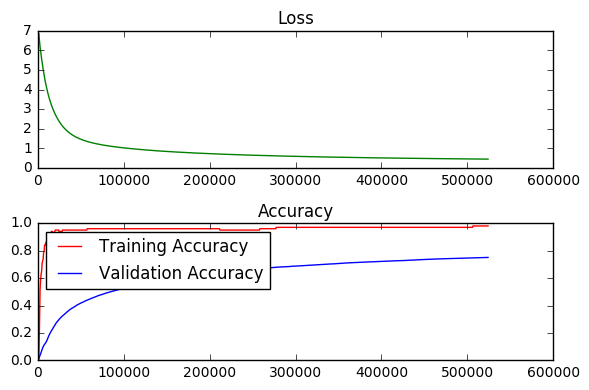

Accuracy on test-set: 75.3%


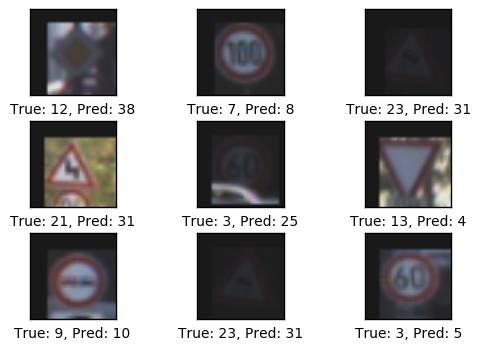

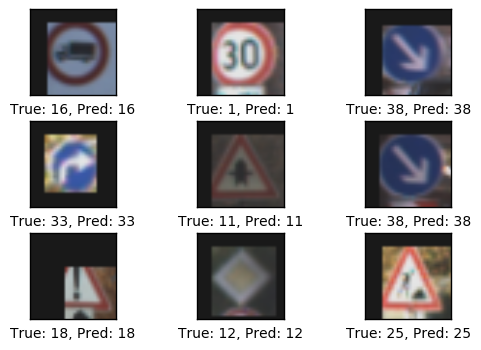

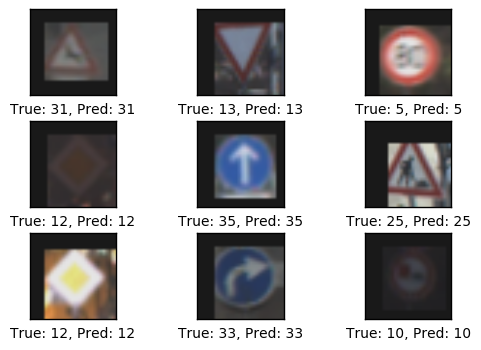

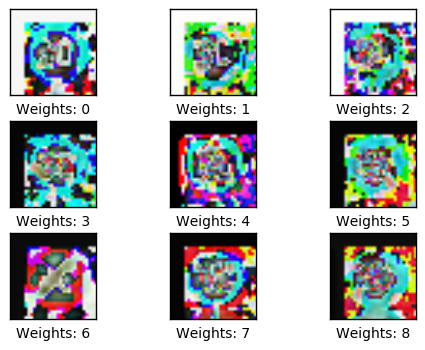

In [50]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_example_success()
plot_weights(weights)

In [52]:
optimize(num_iterations=200)

Iterations  2/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750752


Iterations  3/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750752


Iterations  4/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750831


Iterations  5/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750911


Iterations  6/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750831


Iterations  7/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.750911


Iterations  8/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75099


Iterations  9/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75099


Iterations 10/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.751148


Iterations 11/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.751227


Iterations 12/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.751386


Iterations 13/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.751386


Iterations 14/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.751465


Iterations 15/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.751623


Iterations 16/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.751861


Iterations 17/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75194


Iterations 18/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752098


Iterations 19/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752177


Iterations 20/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752257


Iterations 21/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752257


Iterations 22/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752257


Iterations 23/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752336


Iterations 24/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752494


Iterations 25/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752494


Iterations 26/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752573


Iterations 27/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752652


Iterations 28/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752652


Iterations 29/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752969


Iterations 30/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.752969


Iterations 31/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753207


Iterations 32/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753286


Iterations 33/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753444


Iterations 34/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753444


Iterations 35/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753523


Iterations 36/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753523


Iterations 37/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753603


Iterations 38/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753603


Iterations 39/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753682


Iterations 40/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753682


Iterations 41/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753761


Iterations 42/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.753919


Iterations 43/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.754157


Iterations 44/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.754157


Iterations 45/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.754157


Iterations 46/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.754157


Iterations 47/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.754315


Iterations 48/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.754394


Iterations 49/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.754473


Iterations 50/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75479


Iterations 51/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.754949


Iterations 52/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755028


Iterations 53/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755107


Iterations 54/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755186


Iterations 55/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755265


Iterations 56/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755424


Iterations 57/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755424


Iterations 58/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755503


Iterations 59/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755503


Iterations 60/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755582


Iterations 61/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755661


Iterations 62/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755661


Iterations 63/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755819


Iterations 64/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755819


Iterations 65/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755899


Iterations 66/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755899


Iterations 67/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755978


Iterations 68/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755978


Iterations 69/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755978


Iterations 70/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755978


Iterations 71/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.755978


Iterations 72/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756057


Iterations 73/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756057


Iterations 74/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756136


Iterations 75/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756136


Iterations 76/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756136


Iterations 77/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756295


Iterations 78/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756374


Iterations 79/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756374


Iterations 80/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756453


Iterations 81/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756611


Iterations 82/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756611


Iterations 83/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75669


Iterations 84/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75677


Iterations 85/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756849


Iterations 86/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.756928


Iterations 87/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757007


Iterations 88/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757007


Iterations 89/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757165


Iterations 90/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757165


Iterations 91/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757165


Iterations 92/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757245


Iterations 93/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757403


Iterations 94/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757403


Iterations 95/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757641


Iterations 96/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757641


Iterations 97/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757957


Iterations 98/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757957


Iterations 99/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757957


Iterations 100/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757957


Iterations 101/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.757957


Iterations 102/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758116


Iterations 103/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758195


Iterations 104/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758195


Iterations 105/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758274


Iterations 106/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758353


Iterations 107/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758353


Iterations 108/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758432


Iterations 109/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758432


Iterations 110/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758591


Iterations 111/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75867


Iterations 112/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75867


Iterations 113/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758749


Iterations 114/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758749


Iterations 115/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758907


Iterations 116/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758987


Iterations 117/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.758987


Iterations 118/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759224


Iterations 119/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759303


Iterations 120/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759303


Iterations 121/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759382


Iterations 122/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759382


Iterations 123/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759462


Iterations 124/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759541


Iterations 125/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.75962


Iterations 126/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759778


Iterations 127/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759937


Iterations 128/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759937


Iterations 129/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.759937


Iterations 130/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760016


Iterations 131/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760016


Iterations 132/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760016


Iterations 133/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760095


Iterations 134/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760174


Iterations 135/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760412


Iterations 136/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760491


Iterations 137/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760491


Iterations 138/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760491


Iterations 139/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760491


Iterations 140/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760491


Iterations 141/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76057


Iterations 142/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76057


Iterations 143/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760728


Iterations 144/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760728


Iterations 145/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760808


Iterations 146/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760808


Iterations 147/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.760887


Iterations 148/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761124


Iterations 149/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761283


Iterations 150/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761283


Iterations 151/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761283


Iterations 152/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761362


Iterations 153/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761362


Iterations 154/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761441


Iterations 155/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761441


Iterations 156/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761362


Iterations 157/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761362


Iterations 158/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761441


Iterations 159/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761599


Iterations 160/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761679


Iterations 161/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761679


Iterations 162/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761758


Iterations 163/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761837


Iterations 164/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761837


Iterations 165/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761916


Iterations 166/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.761995


Iterations 167/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762074


Iterations 168/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762154


Iterations 169/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762233


Iterations 170/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762312


Iterations 171/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762312


Iterations 172/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762391


Iterations 173/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762391


Iterations 174/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762391


Iterations 175/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762391


Iterations 176/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76247


Iterations 177/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762629


Iterations 178/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762708


Iterations 179/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762708


Iterations 180/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762629


Iterations 181/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762708


Iterations 182/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762866


Iterations 183/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762945


Iterations 184/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.762945


Iterations 185/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763025


Iterations 186/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763025


Iterations 187/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763025


Iterations 188/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763104


Iterations 189/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763183


Iterations 190/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763262


Iterations 191/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763341


Iterations 192/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76342


Iterations 193/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76342


Iterations 194/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.7635


Iterations 195/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.7635


Iterations 196/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763737


Iterations 197/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763737


Iterations 198/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763737


Iterations 199/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763816


Iterations 200/200:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763816


Iterations 200/200: 100%|██████████| 393/393 [00:01<00:00, 205.77batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763816


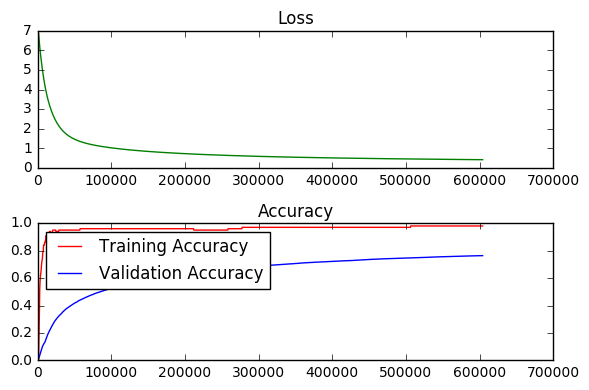

Accuracy on test-set: 76.4%


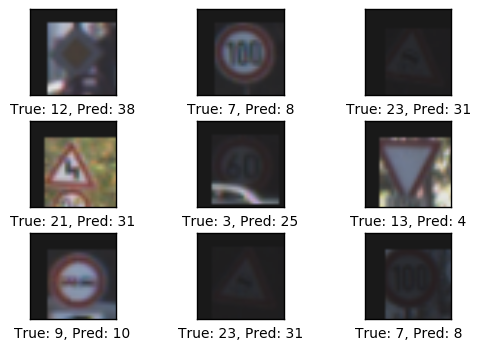

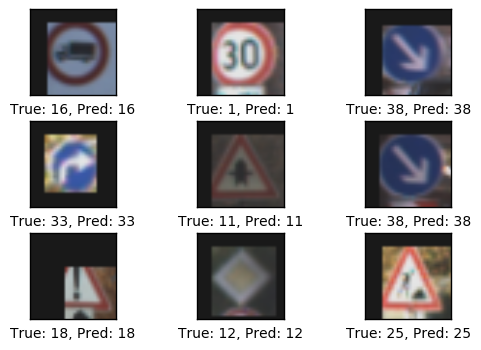

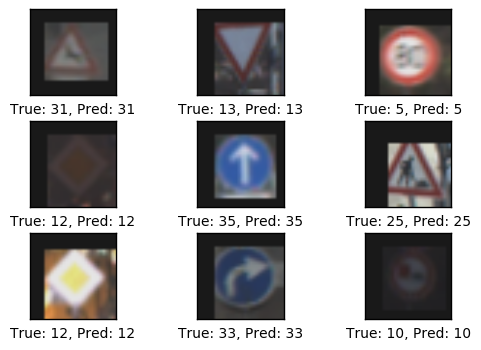

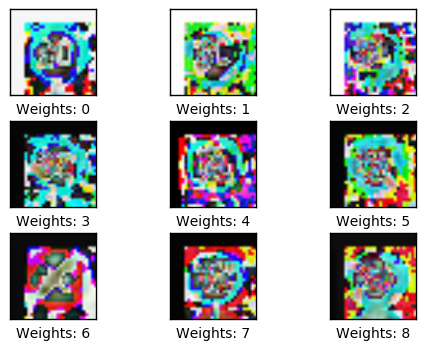

In [53]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_example_success()
plot_weights(weights)

In [55]:
optimize(num_iterations=600)

Iterations  2/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763816


Iterations  3/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763816


Iterations  4/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763896


Iterations  5/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763975


Iterations  6/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.763975


Iterations  7/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764133


Iterations  8/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764133


Iterations  9/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764133


Iterations 10/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764212


Iterations 11/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764212


Iterations 12/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764212


Iterations 13/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764291


Iterations 14/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764371


Iterations 15/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76445


Iterations 16/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76445


Iterations 17/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76445


Iterations 18/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764608


Iterations 19/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764608


Iterations 20/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764608


Iterations 21/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764608


Iterations 22/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764687


Iterations 23/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.764766


Iterations 24/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765004


Iterations 25/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765004


Iterations 26/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765083


Iterations 27/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765162


Iterations 28/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765321


Iterations 29/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765321


Iterations 30/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.7654


Iterations 31/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.7654


Iterations 32/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.7654


Iterations 33/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765479


Iterations 34/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765479


Iterations 35/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765558


Iterations 36/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765558


Iterations 37/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765558


Iterations 38/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765558


Iterations 39/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765717


Iterations 40/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765717


Iterations 41/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765796


Iterations 42/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765796


Iterations 43/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765796


Iterations 44/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765796


Iterations 45/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765717


Iterations 46/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765717


Iterations 47/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765717


Iterations 48/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765796


Iterations 49/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765796


Iterations 50/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765796


Iterations 51/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765796


Iterations 52/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765796


Iterations 53/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.765875


Iterations 54/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766112


Iterations 55/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766112


Iterations 56/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76635


Iterations 57/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76635


Iterations 58/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766429


Iterations 59/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766429


Iterations 60/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766429


Iterations 61/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766429


Iterations 62/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766429


Iterations 63/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766587


Iterations 64/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766667


Iterations 65/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766746


Iterations 66/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766825


Iterations 67/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766825


Iterations 68/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766904


Iterations 69/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766904


Iterations 70/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766983


Iterations 71/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766983


Iterations 72/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.766983


Iterations 73/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.767221


Iterations 74/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.767458


Iterations 75/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.767538


Iterations 76/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.767696


Iterations 77/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.767775


Iterations 78/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.767775


Iterations 79/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.767775


Iterations 80/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.767775


Iterations 81/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768092


Iterations 82/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768092


Iterations 83/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768092


Iterations 84/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768092


Iterations 85/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768171


Iterations 86/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768171


Iterations 87/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768171


Iterations 88/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.76825


Iterations 89/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768329


Iterations 90/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768329


Iterations 91/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768409


Iterations 92/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768409


Iterations 93/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768409


Iterations 94/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768409


Iterations 95/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768409


Iterations 96/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768488


Iterations 97/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768567


Iterations 98/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768567


Iterations 99/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768646


Iterations 100/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768646


Iterations 101/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768725


Iterations 102/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768884


Iterations 103/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.768963


Iterations 104/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769042


Iterations 105/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.7692


Iterations 106/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769279


Iterations 107/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769359


Iterations 108/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769359


Iterations 109/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769517


Iterations 110/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769596


Iterations 111/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769596


Iterations 112/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769596


Iterations 113/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769675


Iterations 114/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769675


Iterations 115/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769755


Iterations 116/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769755


Iterations 117/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769834


Iterations 118/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.769992


Iterations 119/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.770071


Iterations 120/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.770071


Iterations 121/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.770071


Iterations 122/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77023


Iterations 123/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77023


Iterations 124/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77023


Iterations 125/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77023


Iterations 126/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77023


Iterations 127/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77023


Iterations 128/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.770388


Iterations 129/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.770546


Iterations 130/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.770705


Iterations 131/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.770705


Iterations 132/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.770863


Iterations 133/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771021


Iterations 134/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771021


Iterations 135/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771101


Iterations 136/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771101


Iterations 137/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771101


Iterations 138/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771101


Iterations 139/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771259


Iterations 140/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771338


Iterations 141/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771338


Iterations 142/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771338


Iterations 143/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771417


Iterations 144/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771496


Iterations 145/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771496


Iterations 146/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771496


Iterations 147/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771576


Iterations 148/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771655


Iterations 149/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771734


Iterations 150/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771813


Iterations 151/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771813


Iterations 152/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771813


Iterations 153/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771892


Iterations 154/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771892


Iterations 155/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.771972


Iterations 156/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772051


Iterations 157/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772051


Iterations 158/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77213


Iterations 159/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77213


Iterations 160/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772209


Iterations 161/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772209


Iterations 162/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772288


Iterations 163/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772367


Iterations 164/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772367


Iterations 165/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772367


Iterations 166/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772367


Iterations 167/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772367


Iterations 168/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772288


Iterations 169/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772288


Iterations 170/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772288


Iterations 171/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772288


Iterations 172/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772447


Iterations 173/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772684


Iterations 174/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772684


Iterations 175/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772684


Iterations 176/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772684


Iterations 177/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772684


Iterations 178/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772684


Iterations 179/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772684


Iterations 180/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772763


Iterations 181/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.772922


Iterations 182/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773001


Iterations 183/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77308


Iterations 184/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77308


Iterations 185/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77308


Iterations 186/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773159


Iterations 187/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773159


Iterations 188/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773238


Iterations 189/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773397


Iterations 190/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773476


Iterations 191/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773476


Iterations 192/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773476


Iterations 193/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773476


Iterations 194/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773476


Iterations 195/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773555


Iterations 196/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773634


Iterations 197/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773634


Iterations 198/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773713


Iterations 199/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773793


Iterations 200/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773872


Iterations 201/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773951


Iterations 202/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.773951


Iterations 203/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77403


Iterations 204/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774109


Iterations 205/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774426


Iterations 206/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774505


Iterations 207/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774584


Iterations 208/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774584


Iterations 209/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774743


Iterations 210/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774743


Iterations 211/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774743


Iterations 212/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774822


Iterations 213/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774822


Iterations 214/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774822


Iterations 215/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774822


Iterations 216/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774822


Iterations 217/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774822


Iterations 218/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774901


Iterations 219/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774901


Iterations 220/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.774901


Iterations 221/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77498


Iterations 222/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77498


Iterations 223/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77498


Iterations 224/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77498


Iterations 225/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775059


Iterations 226/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775139


Iterations 227/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775139


Iterations 228/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775218


Iterations 229/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775218


Iterations 230/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775218


Iterations 231/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775297


Iterations 232/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775376


Iterations 233/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775534


Iterations 234/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775534


Iterations 235/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775614


Iterations 236/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775693


Iterations 237/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775693


Iterations 238/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775693


Iterations 239/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.775851


Iterations 240/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77593


Iterations 241/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77601


Iterations 242/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776089


Iterations 243/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776089


Iterations 244/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776247


Iterations 245/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776326


Iterations 246/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776326


Iterations 247/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776326


Iterations 248/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776405


Iterations 249/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776485


Iterations 250/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776485


Iterations 251/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776485


Iterations 252/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776564


Iterations 253/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776564


Iterations 254/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776564


Iterations 255/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776564


Iterations 256/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776643


Iterations 257/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776643


Iterations 258/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776643


Iterations 259/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776643


Iterations 260/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776643


Iterations 261/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776643


Iterations 262/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776643


Iterations 263/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776722


Iterations 264/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776801


Iterations 265/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776801


Iterations 266/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.776801


Iterations 267/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77688


Iterations 268/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77688


Iterations 269/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777039


Iterations 270/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777118


Iterations 271/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777118


Iterations 272/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777118


Iterations 273/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777118


Iterations 274/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777118


Iterations 275/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777118


Iterations 276/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777118


Iterations 277/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777197


Iterations 278/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777197


Iterations 279/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777276


Iterations 280/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777355


Iterations 281/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777435


Iterations 282/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777435


Iterations 283/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777514


Iterations 284/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777593


Iterations 285/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777593


Iterations 286/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777593


Iterations 287/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777593


Iterations 288/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777593


Iterations 289/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777593


Iterations 290/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777593


Iterations 291/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777672


Iterations 292/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777672


Iterations 293/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777751


Iterations 294/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777831


Iterations 295/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777831


Iterations 296/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777831


Iterations 297/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.777831


Iterations 298/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77791


Iterations 299/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778068


Iterations 300/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778068


Iterations 301/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778068


Iterations 302/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778147


Iterations 303/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778147


Iterations 304/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778147


Iterations 305/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778226


Iterations 306/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778226


Iterations 307/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778306


Iterations 308/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778464


Iterations 309/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778464


Iterations 310/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778464


Iterations 311/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778464


Iterations 312/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778543


Iterations 313/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778543


Iterations 314/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778543


Iterations 315/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778622


Iterations 316/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778701


Iterations 317/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778701


Iterations 318/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778781


Iterations 319/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77886


Iterations 320/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77886


Iterations 321/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77886


Iterations 322/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778781


Iterations 323/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778781


Iterations 324/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.778781


Iterations 325/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.77886


Iterations 326/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779018


Iterations 327/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779097


Iterations 328/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779177


Iterations 329/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779256


Iterations 330/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779256


Iterations 331/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779335


Iterations 332/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779414


Iterations 333/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779335


Iterations 334/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779335


Iterations 335/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779335


Iterations 336/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779414


Iterations 337/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779414


Iterations 338/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779652


Iterations 339/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779652


Iterations 340/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779652


Iterations 341/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779731


Iterations 342/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779968


Iterations 343/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.779968


Iterations 344/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780047


Iterations 345/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780047


Iterations 346/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780047


Iterations 347/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780127


Iterations 348/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780285


Iterations 349/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780443


Iterations 350/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780523


Iterations 351/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780523


Iterations 352/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780523


Iterations 353/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780602


Iterations 354/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780681


Iterations 355/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780681


Iterations 356/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78076


Iterations 357/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78076


Iterations 358/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780918


Iterations 359/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780918


Iterations 360/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780998


Iterations 361/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780998


Iterations 362/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780998


Iterations 363/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781077


Iterations 364/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781077


Iterations 365/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.780998


Iterations 366/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781235


Iterations 367/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781235


Iterations 368/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781314


Iterations 369/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781394


Iterations 370/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781394


Iterations 371/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781473


Iterations 372/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781473


Iterations 373/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781473


Iterations 374/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781473


Iterations 375/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781473


Iterations 376/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781473


Iterations 377/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781789


Iterations 378/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781869


Iterations 379/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781948


Iterations 380/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781948


Iterations 381/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781948


Iterations 382/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.781948


Iterations 383/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782027


Iterations 384/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782027


Iterations 385/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782264


Iterations 386/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782264


Iterations 387/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782423


Iterations 388/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782502


Iterations 389/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782502


Iterations 390/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782502


Iterations 391/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78266


Iterations 392/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78266


Iterations 393/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78274


Iterations 394/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782898


Iterations 395/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782977


Iterations 396/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782977


Iterations 397/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.782977


Iterations 398/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783056


Iterations 399/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783056


Iterations 400/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783135


Iterations 401/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783294


Iterations 402/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783294


Iterations 403/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783373


Iterations 404/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783452


Iterations 405/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783531


Iterations 406/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78361


Iterations 407/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78361


Iterations 408/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78361


Iterations 409/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78369


Iterations 410/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78369


Iterations 411/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78369


Iterations 412/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783848


Iterations 413/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.783927


Iterations 414/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784006


Iterations 415/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784006


Iterations 416/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784006


Iterations 417/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784006


Iterations 418/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784086


Iterations 419/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784086


Iterations 420/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784086


Iterations 421/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784244


Iterations 422/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784402


Iterations 423/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784402


Iterations 424/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784402


Iterations 425/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784402


Iterations 426/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784402


Iterations 427/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784402


Iterations 428/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784561


Iterations 429/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784561


Iterations 430/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78464


Iterations 431/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784719


Iterations 432/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784719


Iterations 433/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784719


Iterations 434/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784719


Iterations 435/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784719


Iterations 436/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784798


Iterations 437/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784798


Iterations 438/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784877


Iterations 439/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784877


Iterations 440/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784877


Iterations 441/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784877


Iterations 442/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.784877


Iterations 443/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785036


Iterations 444/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785115


Iterations 445/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785115


Iterations 446/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785115


Iterations 447/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785115


Iterations 448/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785115


Iterations 449/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785115


Iterations 450/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785115


Iterations 451/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785115


Iterations 452/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785115


Iterations 453/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785194


Iterations 454/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785194


Iterations 455/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785194


Iterations 456/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785194


Iterations 457/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785194


Iterations 458/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785194


Iterations 459/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785273


Iterations 460/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785273


Iterations 461/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785273


Iterations 462/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785273


Iterations 463/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785352


Iterations 464/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785352


Iterations 465/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785352


Iterations 466/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785432


Iterations 467/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785511


Iterations 468/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785511


Iterations 469/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785511


Iterations 470/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78559


Iterations 471/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78559


Iterations 472/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78559


Iterations 473/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785669


Iterations 474/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785907


Iterations 475/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785907


Iterations 476/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.785986


Iterations 477/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786065


Iterations 478/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786065


Iterations 479/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786065


Iterations 480/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786065


Iterations 481/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786065


Iterations 482/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786065


Iterations 483/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786144


Iterations 484/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786144


Iterations 485/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786144


Iterations 486/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786144


Iterations 487/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786144


Iterations 488/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786144


Iterations 489/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786223


Iterations 490/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786223


Iterations 491/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786302


Iterations 492/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786382


Iterations 493/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786461


Iterations 494/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78654


Iterations 495/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78654


Iterations 496/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78654


Iterations 497/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78654


Iterations 498/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78654


Iterations 499/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78654


Iterations 500/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78654


Iterations 501/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78654


Iterations 502/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78654


Iterations 503/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786619


Iterations 504/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786619


Iterations 505/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786698


Iterations 506/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786777


Iterations 507/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.786936


Iterations 508/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787015


Iterations 509/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787015


Iterations 510/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787094


Iterations 511/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787094


Iterations 512/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787173


Iterations 513/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787173


Iterations 514/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787173


Iterations 515/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787253


Iterations 516/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787253


Iterations 517/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787332


Iterations 518/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787332


Iterations 519/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787332


Iterations 520/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78749


Iterations 521/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78749


Iterations 522/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78749


Iterations 523/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78749


Iterations 524/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78749


Iterations 525/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78749


Iterations 526/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787569


Iterations 527/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787569


Iterations 528/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787648


Iterations 529/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787728


Iterations 530/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787807


Iterations 531/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787807


Iterations 532/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787886


Iterations 533/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.787965


Iterations 534/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788044


Iterations 535/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788044


Iterations 536/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788044


Iterations 537/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788123


Iterations 538/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788123


Iterations 539/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788123


Iterations 540/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788203


Iterations 541/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788203


Iterations 542/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788203


Iterations 543/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788203


Iterations 544/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788203


Iterations 545/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788282


Iterations 546/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788282


Iterations 547/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788282


Iterations 548/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788361


Iterations 549/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788361


Iterations 550/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788361


Iterations 551/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788361


Iterations 552/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788519


Iterations 553/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788519


Iterations 554/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788519


Iterations 555/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788519


Iterations 556/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788599


Iterations 557/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788599


Iterations 558/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788678


Iterations 559/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788678


Iterations 560/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788599


Iterations 561/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788678


Iterations 562/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788757


Iterations 563/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788757


Iterations 564/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788757


Iterations 565/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788757


Iterations 566/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788757


Iterations 567/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788757


Iterations 568/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788836


Iterations 569/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788915


Iterations 570/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788994


Iterations 571/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789074


Iterations 572/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789074


Iterations 573/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789074


Iterations 574/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789074


Iterations 575/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789074


Iterations 576/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788994


Iterations 577/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.788994


Iterations 578/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789074


Iterations 579/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789074


Iterations 580/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789153


Iterations 581/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789153


Iterations 582/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789153


Iterations 583/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789232


Iterations 584/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789311


Iterations 585/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78947


Iterations 586/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78947


Iterations 587/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78947


Iterations 588/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.78947


Iterations 589/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789707


Iterations 590/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789786


Iterations 591/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789786


Iterations 592/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789786


Iterations 593/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789707


Iterations 594/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789786


Iterations 595/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789865


Iterations 596/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789945


Iterations 597/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789945


Iterations 598/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.789945


Iterations 599/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790024


Iterations 600/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790024


Iterations 600/600: 100%|██████████| 393/393 [00:02<00:00, 196.25batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790024


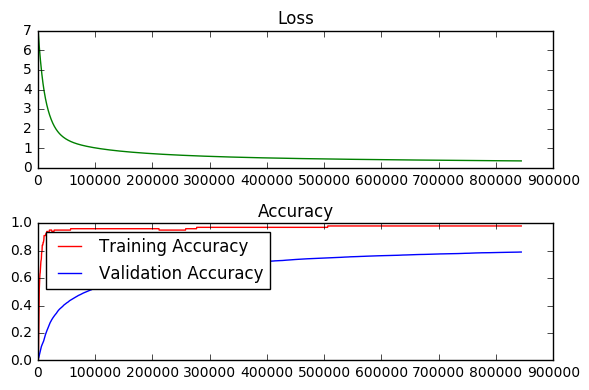

Accuracy on test-set: 78.9%


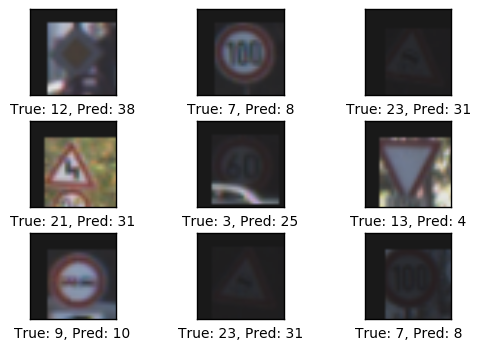

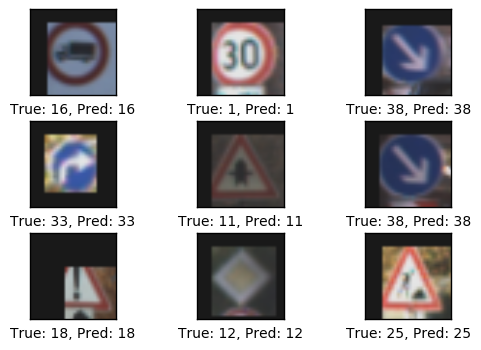

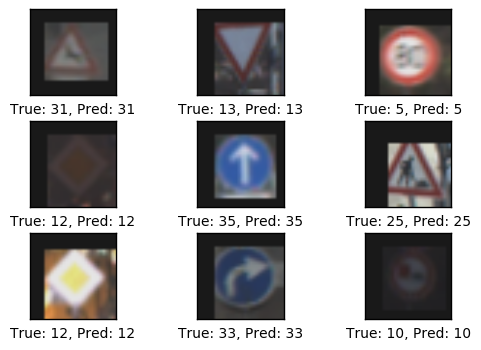

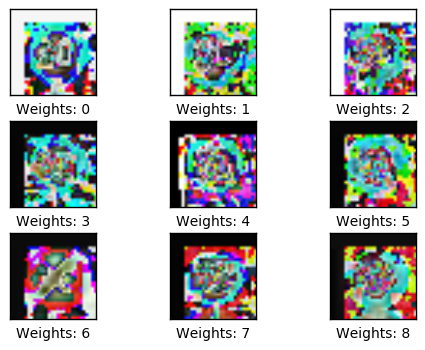

In [56]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_example_success()
plot_weights(weights)

In [ ]:
optimize(num_iterations=600)

Iterations  2/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790024


Iterations  3/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790024


Iterations  4/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790024


Iterations  5/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790103


Iterations  6/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790103


Iterations  7/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790103


Iterations  8/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790182


Iterations  9/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790261


Iterations 10/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790261


Iterations 11/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790261


Iterations 12/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79042


Iterations 13/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79042


Iterations 14/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79042


Iterations 15/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79042


Iterations 16/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79042


Iterations 17/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79042


Iterations 18/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79042


Iterations 19/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79042


Iterations 20/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790499


Iterations 21/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790499


Iterations 22/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790499


Iterations 23/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 24/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 25/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 26/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 27/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 28/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 29/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 30/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 31/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 32/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790578


Iterations 33/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790657


Iterations 34/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790816


Iterations 35/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790816


Iterations 36/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790816


Iterations 37/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790895


Iterations 38/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790895


Iterations 39/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790895


Iterations 40/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790895


Iterations 41/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790974


Iterations 42/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790974


Iterations 43/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790974


Iterations 44/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790974


Iterations 45/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790974


Iterations 46/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.790974


Iterations 47/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791053


Iterations 48/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791132


Iterations 49/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791132


Iterations 50/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791132


Iterations 51/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791132


Iterations 52/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791132


Iterations 53/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791132


Iterations 54/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791291


Iterations 55/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791291


Iterations 56/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791291


Iterations 57/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791291


Iterations 58/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791449


Iterations 59/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791449


Iterations 60/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791449


Iterations 61/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791528


Iterations 62/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791449


Iterations 63/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791528


Iterations 64/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791528


Iterations 65/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791607


Iterations 66/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791686


Iterations 67/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791766


Iterations 68/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791845


Iterations 69/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791845


Iterations 70/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791845


Iterations 71/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791924


Iterations 72/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791924


Iterations 73/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.791924


Iterations 74/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792003


Iterations 75/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792003


Iterations 76/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792003


Iterations 77/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792003


Iterations 78/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792082


Iterations 79/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792162


Iterations 80/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792162


Iterations 81/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792162


Iterations 82/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792241


Iterations 83/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79232


Iterations 84/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792399


Iterations 85/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792399


Iterations 86/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792399


Iterations 87/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792399


Iterations 88/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792478


Iterations 89/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792557


Iterations 90/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792478


Iterations 91/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792478


Iterations 92/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792478


Iterations 93/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792478


Iterations 94/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792637


Iterations 95/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792716


Iterations 96/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792716


Iterations 97/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792795


Iterations 98/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792795


Iterations 99/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792795


Iterations 100/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792795


Iterations 101/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792795


Iterations 102/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792795


Iterations 103/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.792874


Iterations 104/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793032


Iterations 105/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793112


Iterations 106/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793112


Iterations 107/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793112


Iterations 108/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793112


Iterations 109/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793191


Iterations 110/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 111/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 112/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 113/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 114/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 115/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 116/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 117/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 118/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793191


Iterations 119/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793191


Iterations 120/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793191


Iterations 121/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 122/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 123/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 124/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 125/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 126/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79327


Iterations 127/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 128/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 129/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 130/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 131/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 132/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 133/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 134/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 135/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 136/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 137/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793508


Iterations 138/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793587


Iterations 139/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793666


Iterations 140/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793666


Iterations 141/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793824


Iterations 142/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793824


Iterations 143/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793824


Iterations 144/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793745


Iterations 145/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793745


Iterations 146/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793824


Iterations 147/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793903


Iterations 148/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793903


Iterations 149/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793903


Iterations 150/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793903


Iterations 151/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793983


Iterations 152/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793983


Iterations 153/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.793983


Iterations 154/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794062


Iterations 155/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 156/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 157/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 158/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 159/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 160/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 161/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 162/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 163/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 164/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 165/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 166/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794141


Iterations 167/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794299


Iterations 168/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794299


Iterations 169/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794299


Iterations 170/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794299


Iterations 171/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794378


Iterations 172/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794378


Iterations 173/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794378


Iterations 174/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794537


Iterations 175/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794537


Iterations 176/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794537


Iterations 177/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794537


Iterations 178/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794537


Iterations 179/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794537


Iterations 180/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794616


Iterations 181/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794695


Iterations 182/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794695


Iterations 183/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794774


Iterations 184/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794695


Iterations 185/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794695


Iterations 186/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794774


Iterations 187/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794774


Iterations 188/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794774


Iterations 189/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.794774


Iterations 190/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795012


Iterations 191/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795012


Iterations 192/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 193/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 194/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 195/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 196/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 197/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 198/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 199/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 200/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 201/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 202/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 203/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795091


Iterations 204/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79517


Iterations 205/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 206/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 207/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 208/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 209/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 210/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 211/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 212/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 213/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 214/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 215/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 216/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 217/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 218/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 219/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 220/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 221/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 222/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795249


Iterations 223/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795408


Iterations 224/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 225/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 226/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 227/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795329


Iterations 228/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795487


Iterations 229/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795487


Iterations 230/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795566


Iterations 231/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795566


Iterations 232/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795645


Iterations 233/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795645


Iterations 234/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795645


Iterations 235/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795645


Iterations 236/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 237/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 238/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 239/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 240/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 241/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 242/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 243/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 244/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 245/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 246/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795724


Iterations 247/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795883


Iterations 248/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795883


Iterations 249/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795883


Iterations 250/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795962


Iterations 251/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.795883


Iterations 252/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796041


Iterations 253/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796041


Iterations 254/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796041


Iterations 255/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79612


Iterations 256/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796279


Iterations 257/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796358


Iterations 258/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796437


Iterations 259/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796437


Iterations 260/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796437


Iterations 261/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796437


Iterations 262/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796437


Iterations 263/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796437


Iterations 264/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796516


Iterations 265/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796516


Iterations 266/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796516


Iterations 267/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796516


Iterations 268/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796516


Iterations 269/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796516


Iterations 270/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796516


Iterations 271/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796595


Iterations 272/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796675


Iterations 273/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796675


Iterations 274/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796675


Iterations 275/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796754


Iterations 276/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796754


Iterations 277/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796754


Iterations 278/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796754


Iterations 279/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796675


Iterations 280/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796675


Iterations 281/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796675


Iterations 282/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796675


Iterations 283/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796675


Iterations 284/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796754


Iterations 285/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796754


Iterations 286/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796754


Iterations 287/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796833


Iterations 288/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796833


Iterations 289/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796833


Iterations 290/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796833


Iterations 291/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796833


Iterations 292/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796833


Iterations 293/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796833


Iterations 294/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796833


Iterations 295/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796833


Iterations 296/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 297/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 298/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 299/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 300/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 301/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 302/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 303/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 304/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 305/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 306/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 307/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 308/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 309/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 310/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.796912


Iterations 311/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79707


Iterations 312/600:   0%|          | 0/393 [00:00<?, ?batches/s]

 Training Accuracy Local= 0.98  Training Accuracy Full= -1  Validation Accuracy= 0.79707


In [ ]:
plot_accuracy()
print_accuracy()
plot_example_errors()
plot_example_success()
plot_weights(weights)

In [ ]:
print_confusion_matrix()

In [ ]:
session.close()

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Preprocessing included - 
1. Resize all images to same size. i.e. (30,30,3)
2. Normalize images to Grey scale.
3. Select the region of interest for all images based on the "coords" array provided along with the image data.

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

Training and Test data was provided along with the project. I was able to achive required 80% accuracy on the test data. To validate the results I created some validation data by downloading some images of traffic signs.

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I created 3 networks - 

1. Project File Name: Traffic_Signs_Recognition_Linear.ipynb
Type: Single layer Linear model. 

2. Project File Name: Traffic_Signs_Recognition_2L_RELU.ipynb
Type: Two Layer deep network. 
Design: "Linear Weights" -> "RELU + Dropout" -> "Output Linear weights". 

3. Project File Name: Traffic_Signs_Recognition_COVNET.ipynb
Type: Convolutional neural network. 
Design: "5x5 Convolutional layer_1" -> "5x5 Conv. layer_2" -> "5x5 Conv. layer_3" -> "fully_connected layer" -> "output layer"

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

To Train the model I used all the parameters mentioned above - optimizer, cost, batch_size, epochs, learning rate and hyperparameters

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

Here are the steps I followed to address the problem -
1) Print the training and test image. This helped me understand the images we are working with.
2) Print the images after pre-processing. This helped me understand how the final input images look like before feeding it to network.
3) Train few iterations of the network at a time and plot all analytics - 
    a) Plot training accuracy, Loss and validation accuracy to check what is the improvement.
    b) Plot final weight images to understand what network is learning over time
    c) Plot confusion matrix to understand what network is doing wrong. This helped me tune some parameters in the input image (such as region of interest selection) to improve the results.
    d) Final Accuracy score.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [ ]:
import glob
image_list = []
for filename in glob.glob('../live-images/*.*'):
    im = cv2.imread(filename)
    print (filename, " - ", type(im))
    image_list.append(im)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.